# DESCRIPTIVE DATA ANALYSIS OF STACK OVER FLOW SURVEY DATA:

> **Author: Alireza Sasani**

> email: alr.sasani@gmail.com

---
---

Importing the required libraries and writing some usfull functions to be used in the analysis

In [72]:
# The libraries required are imported
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from collections import Counter
pd.options.mode.copy_on_write = True
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable


#Function to save a figure:
def save_fig(fig_name='myFig', tight_layout=True, fig_extension="png", resolution=300,IMAGES_PATH=os.getcwd()):
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#Function to plot a histogram using seaborn from a serie
def sns_hist_plot(series,figsize=(6,4),style=None,rotation=0,tight_layout=True,
                  if_preprocess=False,ax=None):
    if isinstance(series,pd.Series):
        if if_preprocess:
            data_dict = text_sep_counter(series,seperator=';',if_count=False)
            plot_data = pd.Series(data_dict)
        else:
            plot_data = series
        figure = plt.figure(figsize=figsize)
        if style is not None:
            plt.style.use(style)
        if tight_layout:
            plt.tight_layout()
        sns.histplot(plot_data,ax=ax)
        plt.xticks(rotation=rotation)
    else:
        raise ("The data should be pands Series type.")

#Function to plot a histogram using seaborn from a serie
def plot_barh(series,figsize=(6,4),style=None,rotation=0,tight_layout=True,
              if_preprocess=False,ax=None,label=None):
    if isinstance(series,pd.Series):
        if if_preprocess:
            data_dict = text_sep_counter(series,seperator=';',if_count=False)
            plot_data = pd.Series(data_dict)
        else:
             plot_data = series
        plt.style.use(style)
        cnt_dta = plot_data.value_counts()
        if tight_layout:
            plt.tight_layout()
        if ax is not None:
            ax.barh(y=cnt_dta.index,width=cnt_dta,label=label)
        else:
            plt.barh(y=cnt_dta.index,width=cnt_dta,label=label)
    else:
        raise ("The data should be pands Series type.")

# A function to preprocess the data where the columns have data seperate by ;.
def text_sep_counter(series,seperator=';',if_count=True):
    series = series.dropna()
    outpt_list = []
    for text in series:
        words = text.split(seperator)
        for word in words:
            outpt_list.append(word)
    if if_count:
        return Counter(outpt_list)
    else:
        return outpt_list

# A function to create a data acceptable for histogram plotting from a columns where dara are separated by ;.
def get_sin_DF(series,sort=True,seperator=';',if_return_hist_data=False):
    my_df = text_sep_counter(series,seperator=seperator,if_count=True)
    my_df = pd.DataFrame(my_df.values(),index=my_df.keys())
    if sort:
        my_df = my_df.sort_values(by=0,ascending=False)
    if if_return_hist_data:
        indxes = my_df.index
        values = my_df.values
        return(indxes,values)
    else:
        return(my_df)

In [73]:
# Getting currency conversion rates to be use in analysis:
from datetime import date
import urllib.request
from currency_converter import ECB_URL, CurrencyConverter
filename = f"Currency_conversion_rates_{date.today():%Y%m%d}.zip"
if not os.path.isfile(filename):
    urllib.request.urlretrieve(ECB_URL, filename)
cc = CurrencyConverter(filename)

---


## Loading and cleaning Data from csv files on PC:

In [3]:
## Loading Data from csv files on PC:
DATA_PATH = Path("/Users/alirezasasani/Documents/Programming/DS_Projects/DATA/stack-overflow-developer-survey-2023")
file_name1 = "survey_results_public.csv"
file_name2 = "survey_results_schema.csv"

**Data is the information from the survey and schema presenting the questions posed to people:**

In [4]:
data_in = pd.read_csv(os.path.join(DATA_PATH,file_name1))
schema = pd.read_csv(os.path.join(DATA_PATH,file_name2))
shape_0 = data_in.shape
data_in.fillna(np.nan,inplace=True)

**DATA CLEANING**
Since we are not going to work with all the results of the survey we will only keep the relevent ones (i.e., till col 45 where we have the relevent data to this analysis + 3 more columns from the lats question of the survey)

In [5]:
data_req = data_in.iloc[:,:45]

In [6]:
data_req.duplicated().value_counts()   # There are no duplicates in the results of the survey

False    89184
Name: count, dtype: int64

Since the survey has got many optional questions there are many null values in this survey so we can not remove all the rows with null values in it but we can see how the number of pariticpants changes if we change the threshold for removing the rows with null values. Finding the good thereshold to remove the rows with more than threshold null columns:

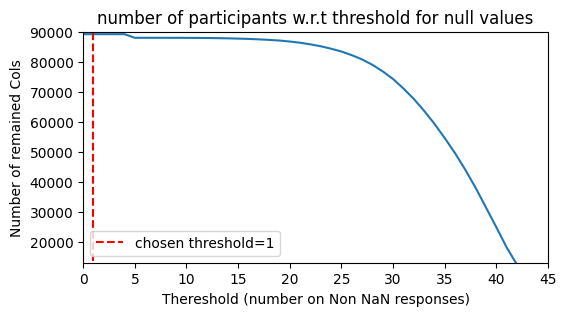

In [7]:
data_temp = []
for i in range(45):
    data_temp.append(data_req.dropna(thresh=i,axis=0).shape[0])

na_threshold = 1 
figure = plt.figure(figsize=(6,3))    
plt.plot(range(45),data_temp)
plt.title('number of participants w.r.t threshold for null values')
plt.xlabel('Thereshold (number on Non NaN responses)')
plt.ylabel('Number of remained Cols')
plt.xlim(0,45)
plt.ylim(13000,90000)
plt.vlines(na_threshold,ymin=10000,ymax=90000,color='red',linestyles='--',label=f'chosen threshold={na_threshold}')
plt.legend()
# fig.tight_layout()
plt.show()
del data_temp

In [8]:
# keeping rwos with less than threshold number of null fields
def get_org_data(data_req=data_req,na_threshold=1):
    data = data_req.dropna(thresh=na_threshold,axis=0)
    print("number of removed rows:",shape_0[0]-data.shape[0])
    return(data)

## Analyzing the data:

**Personal Data**

In [9]:
styles = plt.style.available
plt_style = styles[23]
plot_fig_sizes = (8,4)

In [10]:
data = get_org_data(data_req,na_threshold=1)

number of removed rows: 0


In [11]:
data_cols = data.columns

In [12]:
schema.iloc[5,2]

'Which of the following options best describes you today? For the purpose of this survey, a developer is "someone who writes code". *'

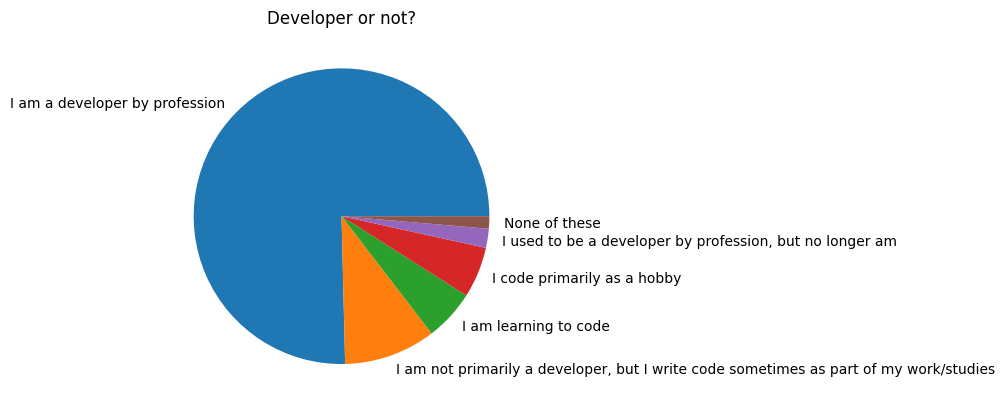

In [13]:
indexs,values = get_sin_DF(data[data_cols[2]],sort=True,seperator=';',if_return_hist_data=True)
plt.pie(values.ravel(),labels=indexs)
plt.title("Developer or not?")
plt.show()

In [15]:
total_people = data[data_cols[3]].count()
prof_dev = data[data[data_cols[2]]=='I am a developer by profession'][data_cols[2]].count()

In [16]:
print('professional developers Percent = ',prof_dev/total_people*100)

professional developers Percent =  75.39132579834948


In [17]:
schema.iloc[6,2]

'What is your age? *'

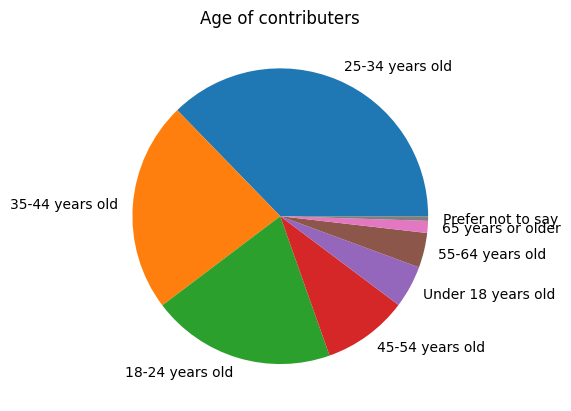

In [21]:
indexs,values = get_sin_DF(data[data_cols[3]],sort=True,seperator=';',if_return_hist_data=True)
plt.pie(values.ravel(),labels=indxes)
plt.title("Age of contributers")
# fig.tight_layout()
plt.show()

In [22]:
age_GP = data.groupby('Age')

In [74]:
print(f"age group 18-24 : {age_GP.get_group('18-24 years old')['Age'].count()/total_people*100 :.2f}% of people")
print(f"age group 25-34 : {age_GP.get_group('25-34 years old')['Age'].count()/total_people*100 :.2f}% of people")
print(f"age group 35-44 : {age_GP.get_group('35-44 years old')['Age'].count()/total_people*100 :.2f}% of people")

age group 18-24 : 20.11% of people
age group 25-34 : 37.28% of people
age group 35-44 : 23.02% of people


In [75]:
DevType_GP = data.groupby(data_cols[2])

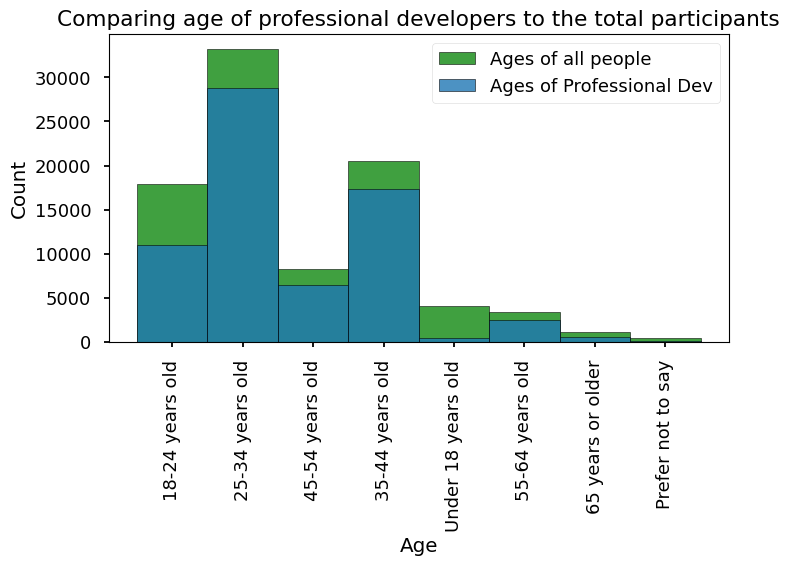

In [81]:
fig = plt.figure(figsize=(8,4))
plt.title("Comparing age of professional developers to the total participants")
sns.histplot(data['Age'],label="Ages of all people",color="Green")
sns.histplot(DevType_GP.get_group('I am a developer by profession')['Age'],label="Ages of Professional Dev",alpha=0.8)
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [26]:
schema.iloc[7,2]

'Which of the following best describes your current employment status? Select all that apply.'

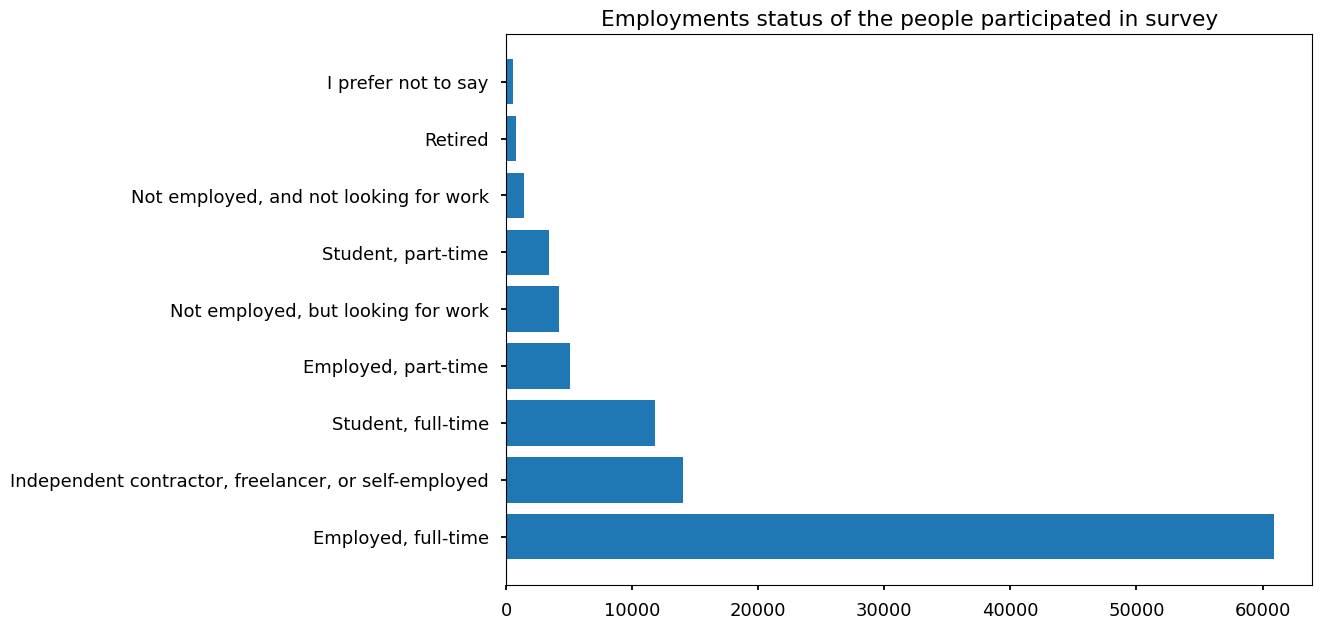

In [27]:
plot_barh(data[data_cols[4]],style=plt_style,if_preprocess=True)
plt.title('Employments status of the people participated in survey')
plt.show()

In [28]:
emp_GP = data.groupby(data_cols[4])

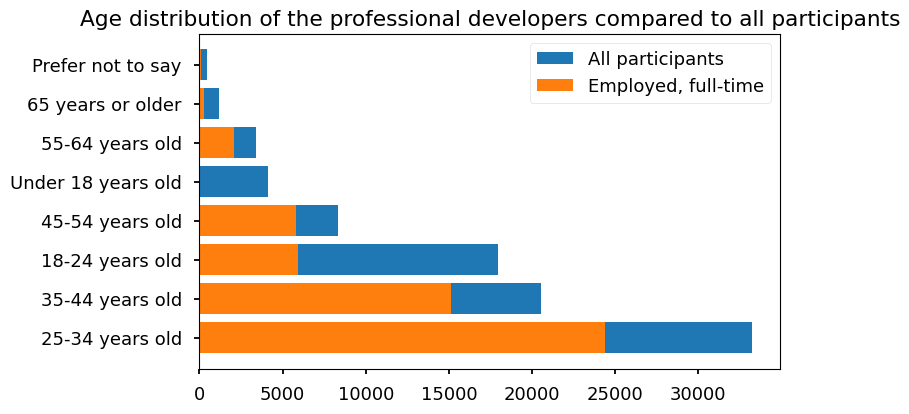

In [82]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_barh(data["Age"],style=plt_style,ax=ax,label="All participants")
plot_barh(emp_GP.get_group('Employed, full-time')["Age"],style=plt_style,ax=ax,label='Employed, full-time')
plt.title('Age distribution of the professional developers compared to all participants')
plt.legend()
plt.show()

In [83]:
schema.iloc[8,2]

'Which best describes your current work situation?'

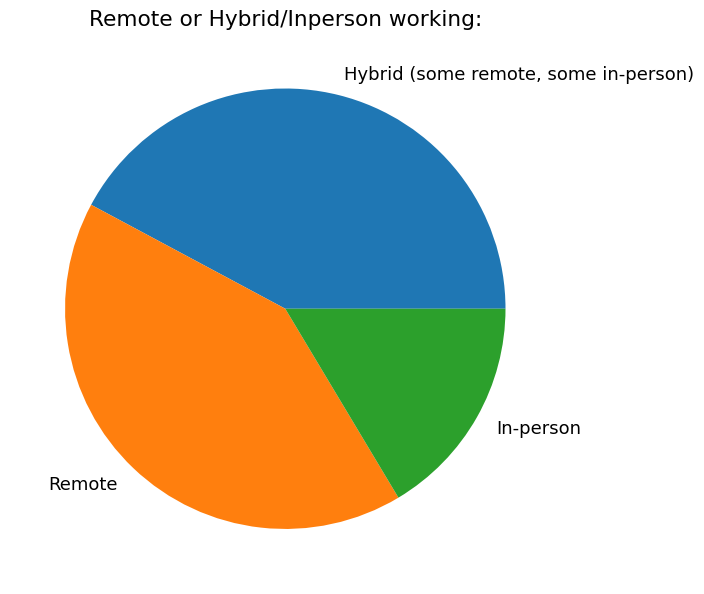

In [90]:
indexs,values = get_sin_DF(data[data_cols[5]],sort=True,seperator=';',if_return_hist_data=True)
plt.pie(values.ravel(),labels=indexs)
plt.title("Remote or Hybrid/Inperson working:")
plt.show()

In [34]:
rem_GP = data.groupby(data_cols[5])

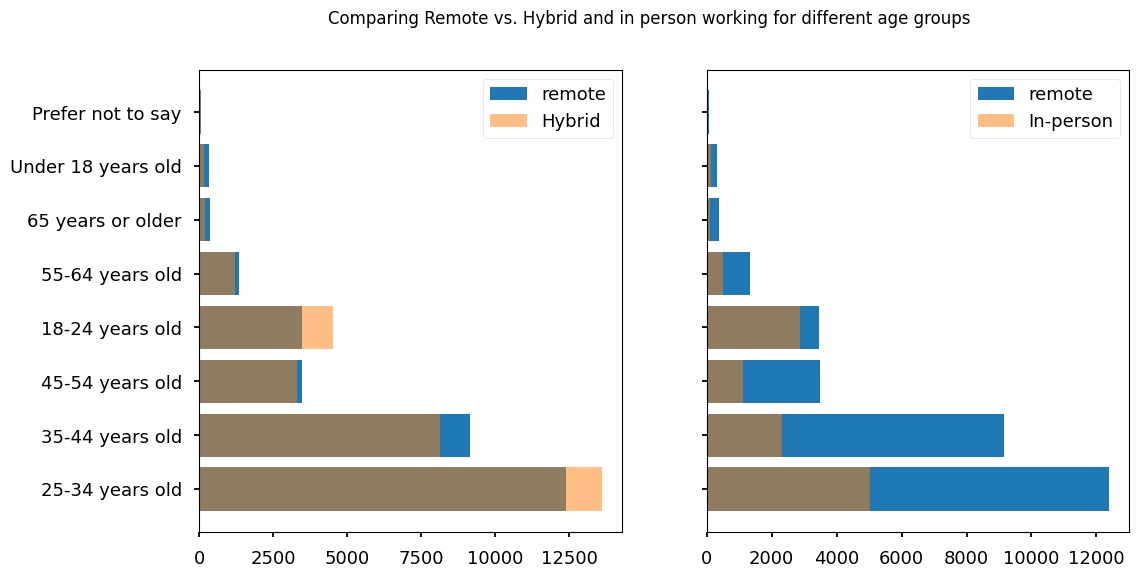

In [35]:
fig,axs = plt.subplots(1,2,figsize=(12,6),sharey=True)
fig.suptitle('Comparing Remote vs. Hybrid and in person working for different age groups')
plot_data=rem_GP.get_group('Remote')['Age']
cnt_dta = plot_data.value_counts()
axs[0].barh(y=cnt_dta.index,width=cnt_dta,label="remote")
axs[1].barh(y=cnt_dta.index,width=cnt_dta,label="remote")
plot_data=rem_GP.get_group('Hybrid (some remote, some in-person)')['Age']
cnt_dta = plot_data.value_counts()
axs[0].barh(y=cnt_dta.index,width=cnt_dta,alpha=0.5,label="Hybrid")
plot_data=rem_GP.get_group('In-person')['Age']
cnt_dta = plot_data.value_counts()
axs[1].barh(y=cnt_dta.index,width=cnt_dta,alpha=0.5,label="In-person")
axs[1].legend()
axs[0].legend()
plt.show()

In [36]:
schema.iloc[9,2]

'Which of the following best describes the code you write outside of work? Select all that apply.'

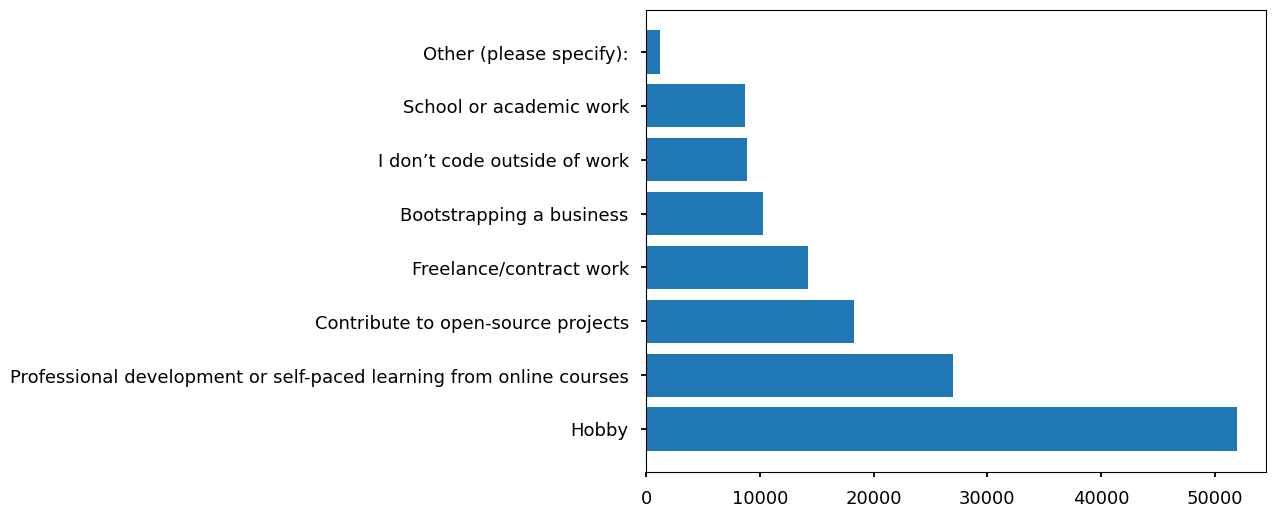

In [91]:
plt.figure(figsize=(8,6))
plot_barh(data[data_cols[6]],if_preprocess=True,style=plt_style)

In [92]:
codout_GP = data.groupby(data_cols[6])

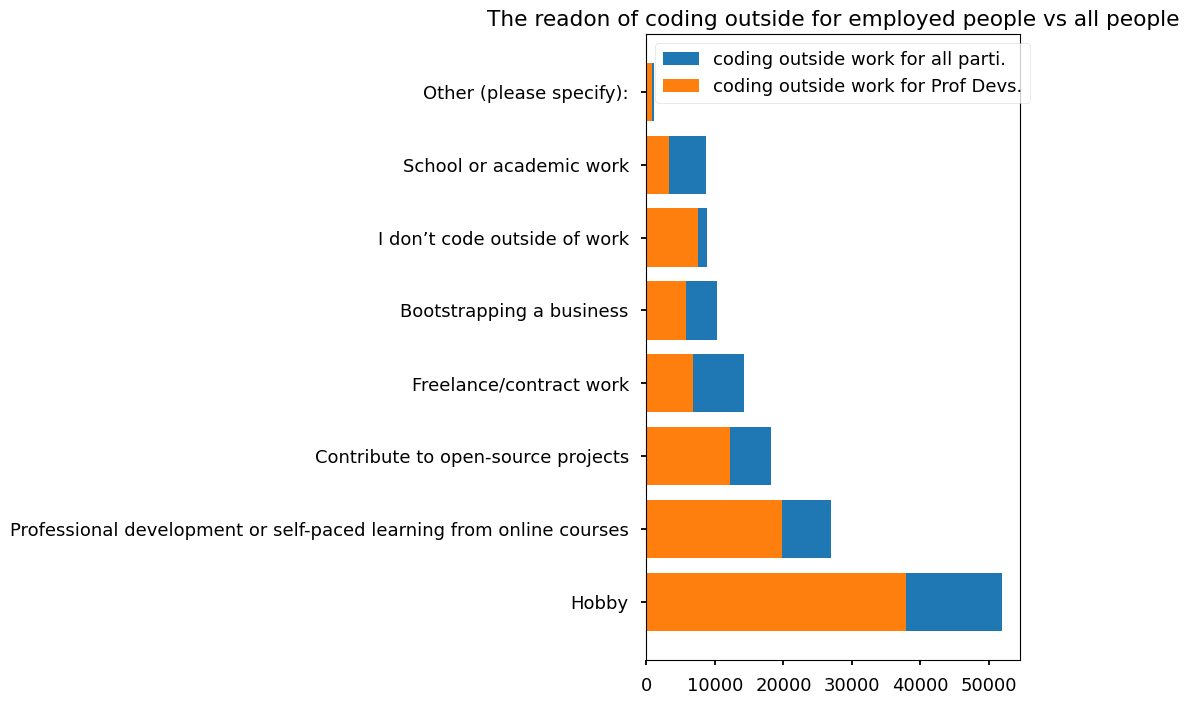

In [93]:
emp_GP.get_group('Employed, full-time')
fig,ax = plt.subplots(1,1)
plt.title("The readon of coding outside for employed people vs all people")
plot_barh(data[data_cols[6]],if_preprocess=True,style=plt_style,ax=ax,label="coding outside work for all parti.")
plot_barh(emp_GP.get_group('Employed, full-time')[data_cols[6]],if_preprocess=True,style=plt_style,
          ax=ax,label="coding outside work for Prof Devs.")
plt.legend()
plt.show()


# Professional Data:

In [94]:
schema.iloc[11,2]

'Which of the following best describes the highest level of formal education that you’ve completed? *'

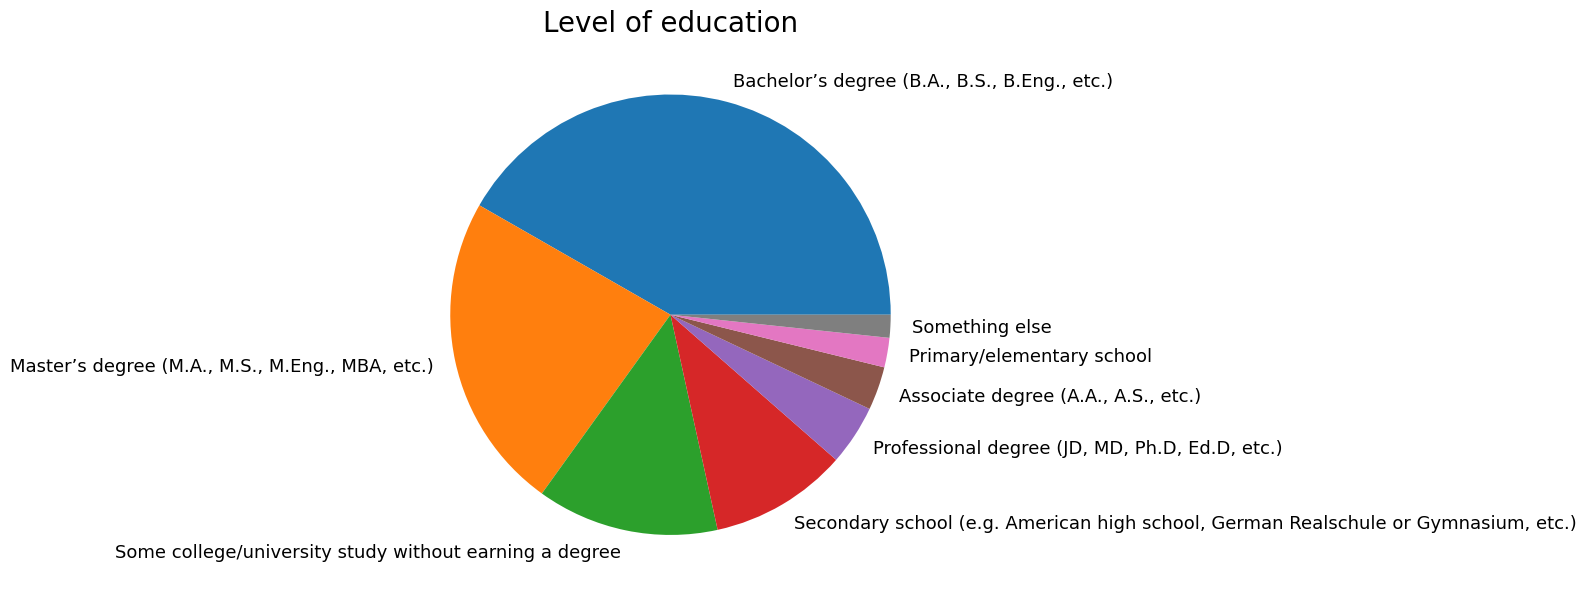

In [96]:
indexs,values = get_sin_DF(data[data_cols[7]],sort=True,seperator=';',if_return_hist_data=True)
fix,ax = plt.subplots()
ax.pie(values.ravel(),labels=indexs)
plt.title("Level of education",fontsize=20)
plt.show()

In [45]:
schema.iloc[12,2]

'How do you learn to code? Select all that apply.'

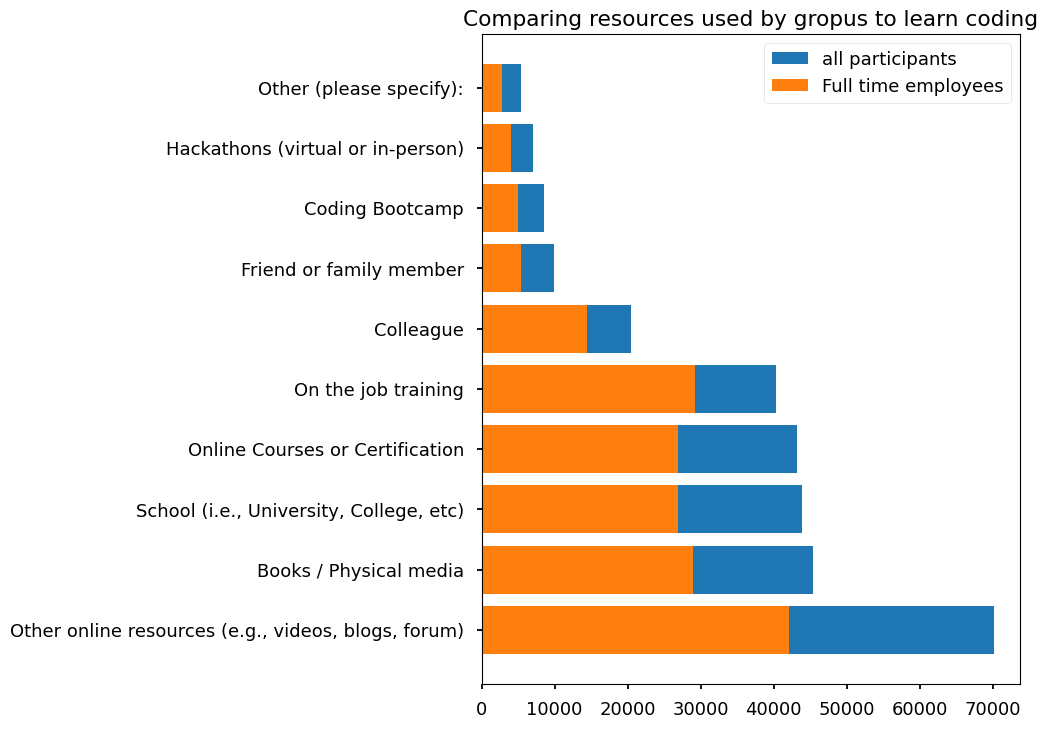

In [97]:
fig,ax = plt.subplots()
plot_barh(data[data_cols[8]],if_preprocess=True,style=plt_style,ax=ax,label="all participants")
plot_barh(emp_GP.get_group('Employed, full-time')[data_cols[8]],if_preprocess=True,
          style=plt_style,ax=ax,label="Full time employees")
plt.legend()
plt.title("Comparing resources used by gropus to learn coding")
plt.show()

In [98]:
schema.iloc[13,2]

'What online resources do you use to learn to code? Select all that apply.'

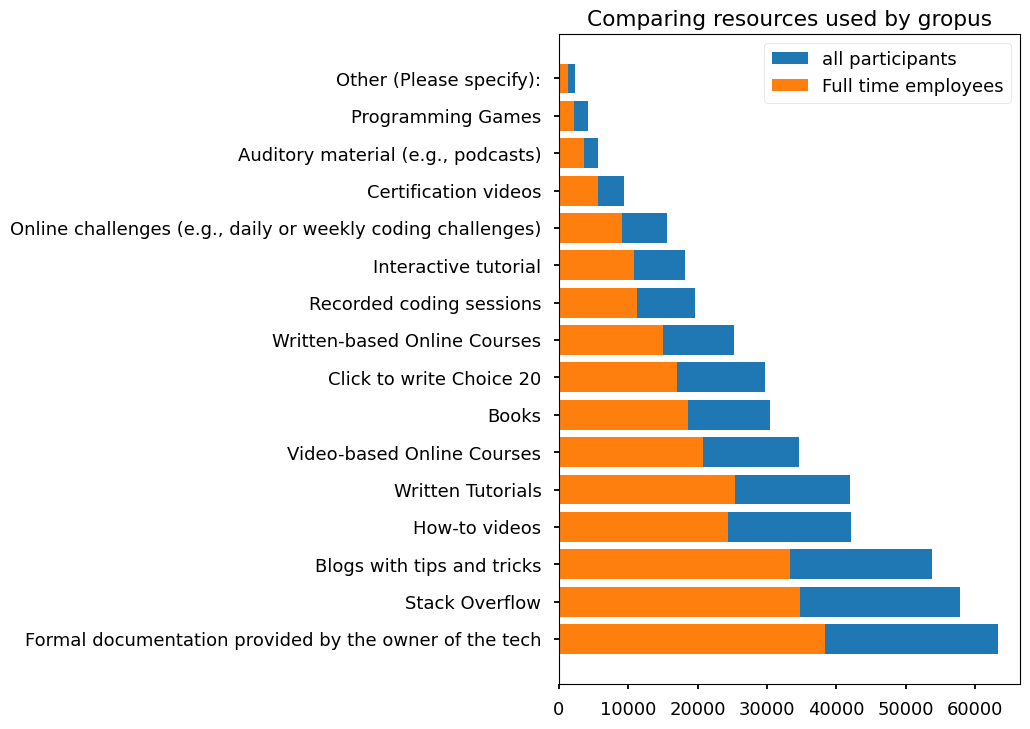

In [99]:
# sns_hist_plot(data,col=data_cols[9],figsize=(8,4),style=styles[14],rotation=90,if_preprocess=True)
# plot_barh(data,data_cols[9],if_preprocess=True,style=plt_style)
fig,ax = plt.subplots()
plot_barh(data[data_cols[9]],if_preprocess=True,style=plt_style,ax=ax,label="all participants")
plot_barh(emp_GP.get_group('Employed, full-time')[data_cols[9]],if_preprocess=True,
          style=plt_style,ax=ax,label="Full time employees")
plt.legend()
plt.title("Comparing resources used by gropus")
plt.show()

In [100]:
schema.iloc[14,2]

'What online courses or certifications do you use to learn to code? Select all that apply.'

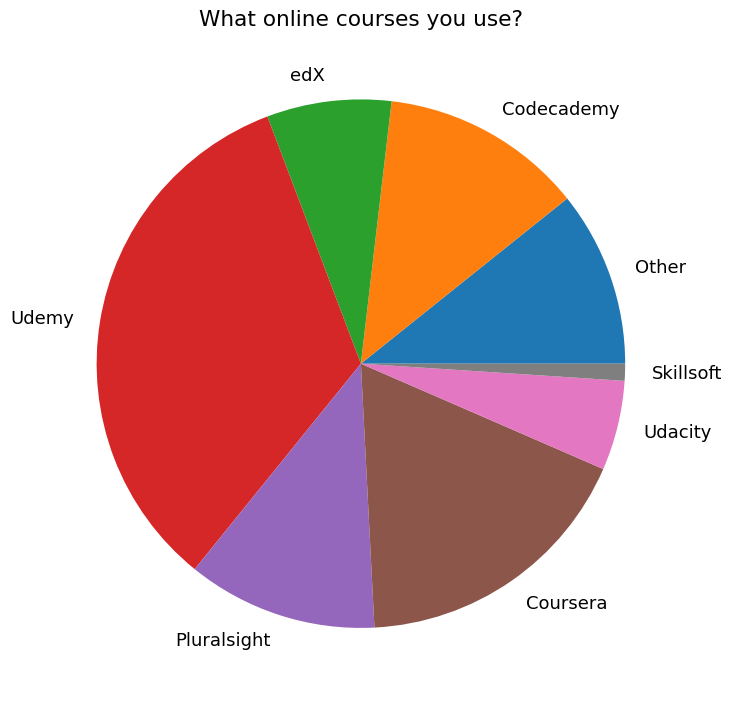

In [101]:
fig, ax = plt.subplots()
plt.title('What online courses you use?')
indexs,values = get_sin_DF(data[data_cols[10]],sort=False,seperator=';',if_return_hist_data=True)
ax.pie(values.ravel(),labels=indexs)
fig.tight_layout()
plt.show()

In [102]:
schema.iloc[15,2]

'Including any education, how many years have you been coding in total?'

In [103]:
data[data_cols[11]]= data[data_cols[11]].replace(["Less than 1 year","More than 50 years"],[0,55])

In [104]:
data[data_cols[11]] = data[data_cols[11]].dropna().astype(int)

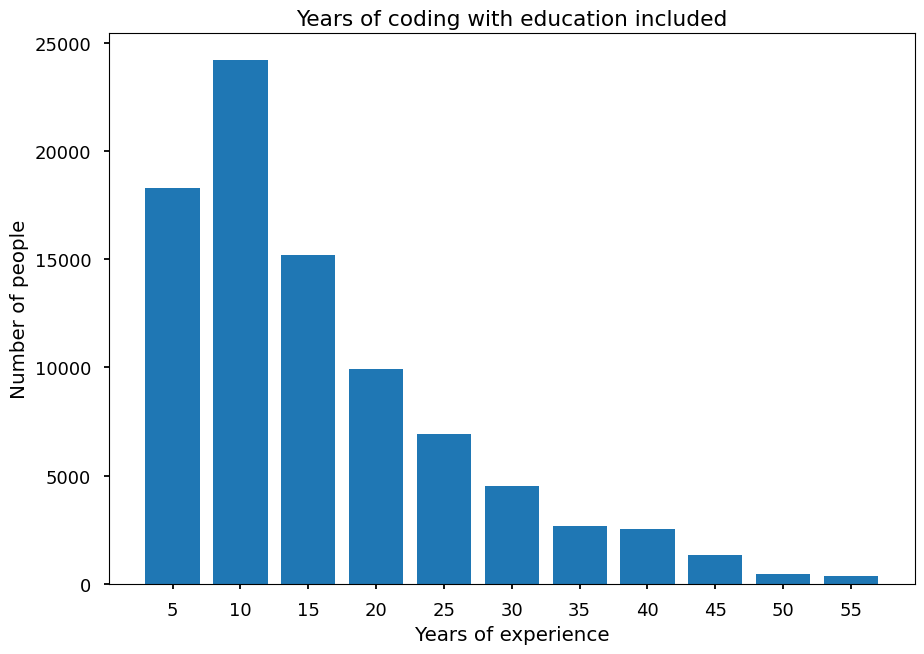

In [105]:
fig,ax = plt.subplots()
bins = np.arange(0,60,5)
labels = [f'{i}' for i in bins[1:]]
dta = pd.cut(data[data_cols[11]],labels=labels,bins=bins)
cnt_dta = dta.value_counts().sort_index()
ax.bar(x=cnt_dta.index,height=cnt_dta.values)
plt.title("Years of coding with education included")
plt.xlabel("Years of experience")
plt.ylabel("Number of people")
# plt.legend()
plt.show()

In [106]:
schema.iloc[16,2]

'NOT including education, how many years have you coded professionally (as a part of your work)?'

In [107]:
data[data_cols[12]]= data[data_cols[12]].replace(["Less than 1 year","More than 50 years"],[0,55])

In [108]:
data[data_cols[12]] = data[data_cols[12]].dropna().astype(int)

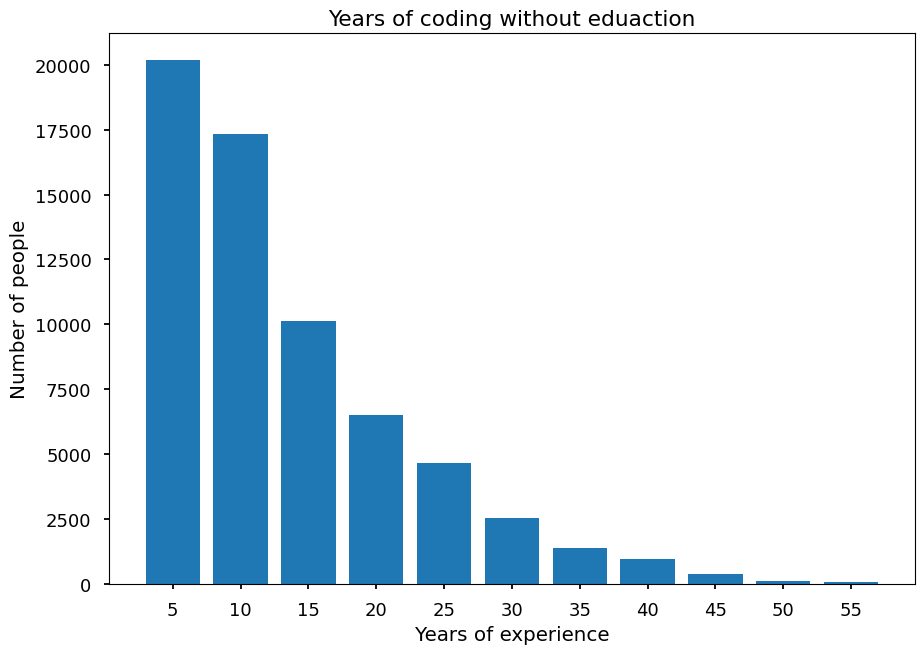

In [61]:
fig,ax = plt.subplots()
bins = np.arange(0,60,5)
labels = [f'{i}' for i in bins[1:]]
dta = pd.cut(data[data_cols[12]],labels=labels,bins=bins)
cnt_dta = dta.value_counts().sort_index()
ax.bar(x=cnt_dta.index,height=cnt_dta.values)
plt.title("Years of coding without eduaction")
plt.xlabel("Years of experience")
plt.ylabel("Number of people")
# plt.legend()
plt.show()

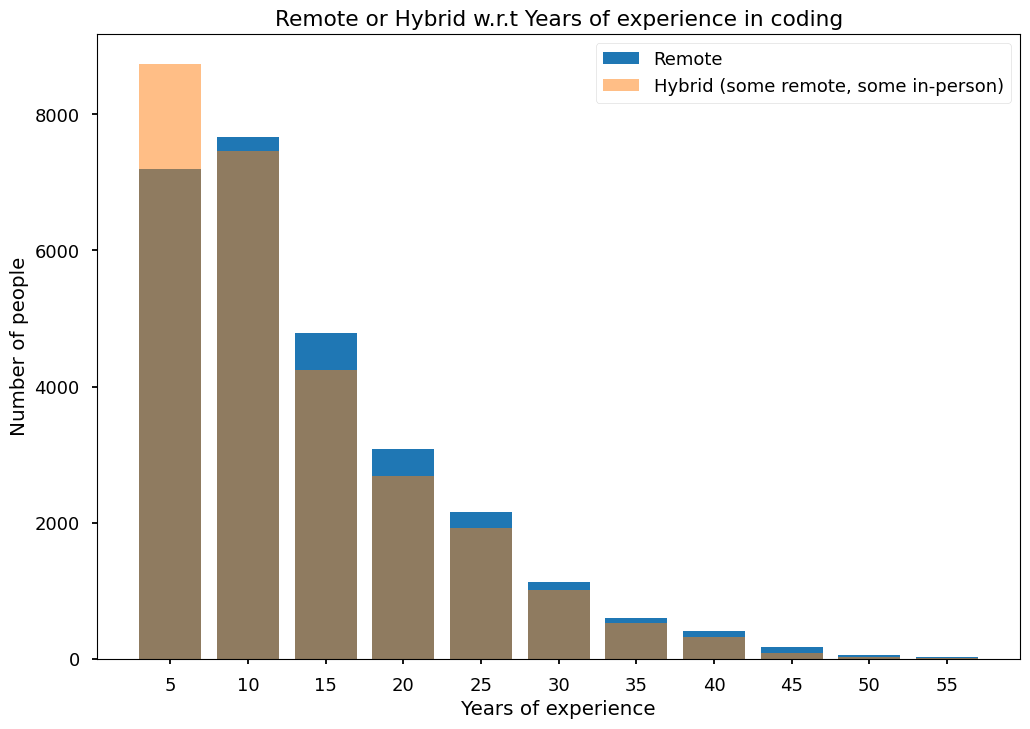

In [109]:
fig,axs = plt.subplots(1,1)
bins = np.arange(0,60,5)
labels = [f'{i}' for i in bins[1:]]
dta = pd.cut(rem_GP.get_group('Remote')[data_cols[12]],labels=labels,bins=bins)
cnt_dta = dta.value_counts().sort_index()
axs.bar(x=cnt_dta.index,height=cnt_dta.values,label='Remote')
dta = pd.cut(rem_GP.get_group('Hybrid (some remote, some in-person)')[data_cols[12]],labels=labels,bins=bins)
cnt_dta = dta.value_counts().sort_index()
axs.bar(x=cnt_dta.index,height=cnt_dta.values,label='Hybrid (some remote, some in-person)',alpha=0.5)
axs.set_xlabel("Years of experience")
axs.set_ylabel("Number of people")
axs.legend()
plt.tight_layout()
plt.title("Remote or Hybrid w.r.t Years of experience in coding")
plt.show()


In [110]:
schema.iloc[17,2]

'Which of the following describes your current job, the one you do most of the time? Please select only one.'

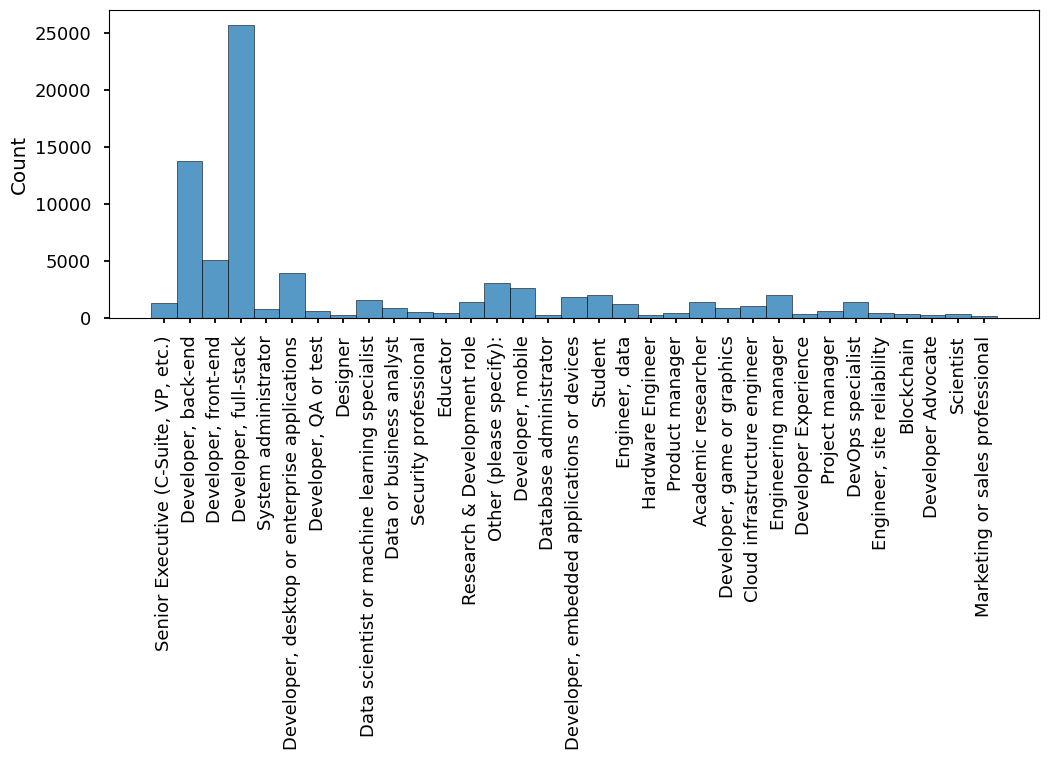

In [111]:
sns_hist_plot(data[data_cols[13]],figsize=(12,4),style=plt_style,rotation=90,if_preprocess=True)

In [112]:
schema.iloc[18,2]

'Approximately how many people are employed by the company or organization you currently work for?  This should only include your primary company, and not the entire holding or parent company if that applies.'

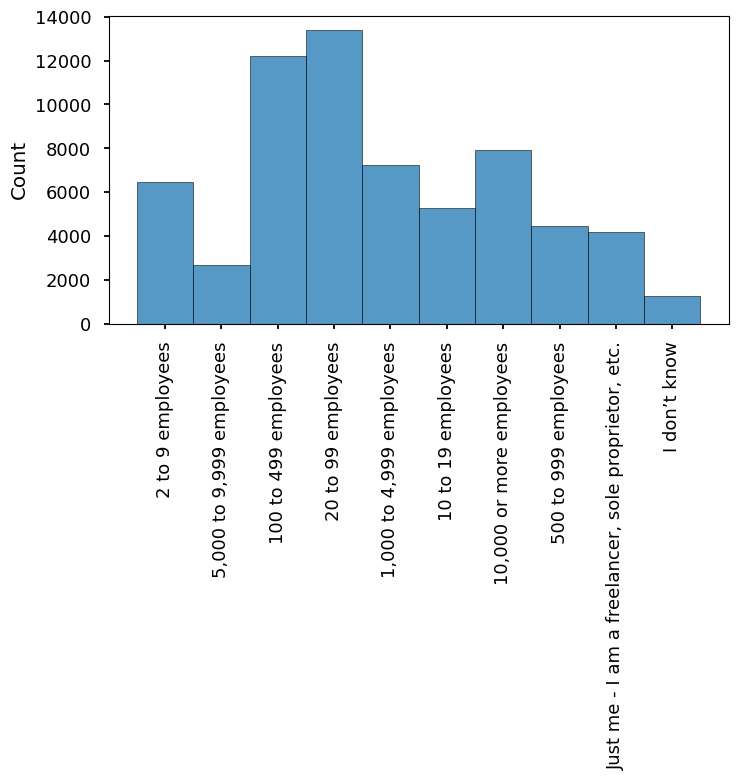

In [113]:
sns_hist_plot(data[data_cols[14]],figsize=(8,4),style=plt_style,rotation=90,if_preprocess=True)

In [114]:
schema.iloc[19,2]

'What level of influence do you, personally, have over new technology purchases at your organization?'

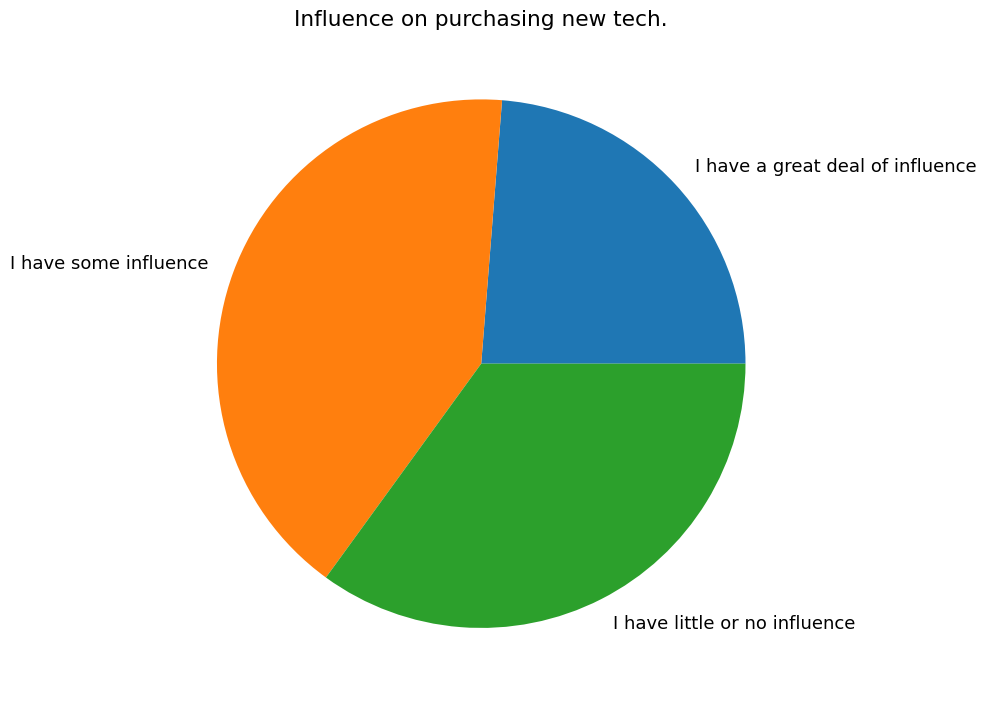

In [119]:
fig, ax = plt.subplots()
plt.title('Influence on purchasing new tech.')
indexs,values = get_sin_DF(data[data_cols[15]],sort=False,seperator=';',if_return_hist_data=True)
ax.pie(values.ravel(),labels=indexs)
fig.tight_layout()
plt.show()

In [69]:
influence_GP = data.groupby(data_cols[15])

In [70]:
influence_GP.groups.keys()

dict_keys(['I have a great deal of influence', 'I have little or no influence', 'I have some influence'])

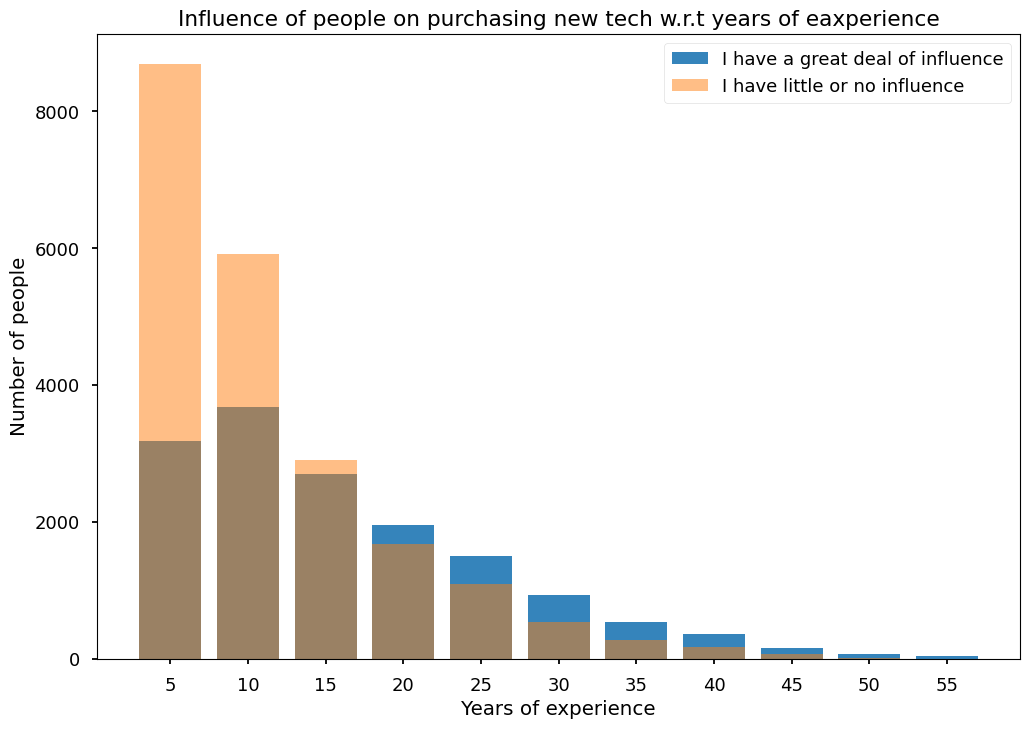

In [121]:
fig,axs = plt.subplots(1,1)
bins = np.arange(0,60,5)
labels = [f'{i}' for i in bins[1:]]
dta = pd.cut(influence_GP.get_group('I have a great deal of influence')[data_cols[12]],labels=labels,bins=bins)
cnt_dta = dta.value_counts().sort_index()
axs.bar(x=cnt_dta.index,height=cnt_dta.values,label='I have a great deal of influence',alpha=0.9)
dta = pd.cut(influence_GP.get_group('I have little or no influence')[data_cols[12]],labels=labels,bins=bins)
cnt_dta = dta.value_counts().sort_index()
axs.bar(x=cnt_dta.index,height=cnt_dta.values,label='I have little or no influence',alpha=0.5)
axs.set_xlabel("Years of experience")
axs.set_ylabel("Number of people")
axs.legend()
plt.tight_layout()
plt.title("Influence of people on purchasing new tech w.r.t years of eaxperience")
plt.show()

In [122]:
schema.iloc[20,2]

'When thinking about new technology purchases at your organization, are you more likely to be given a short list of products/services to evaluate or be told to investigate on your own?'

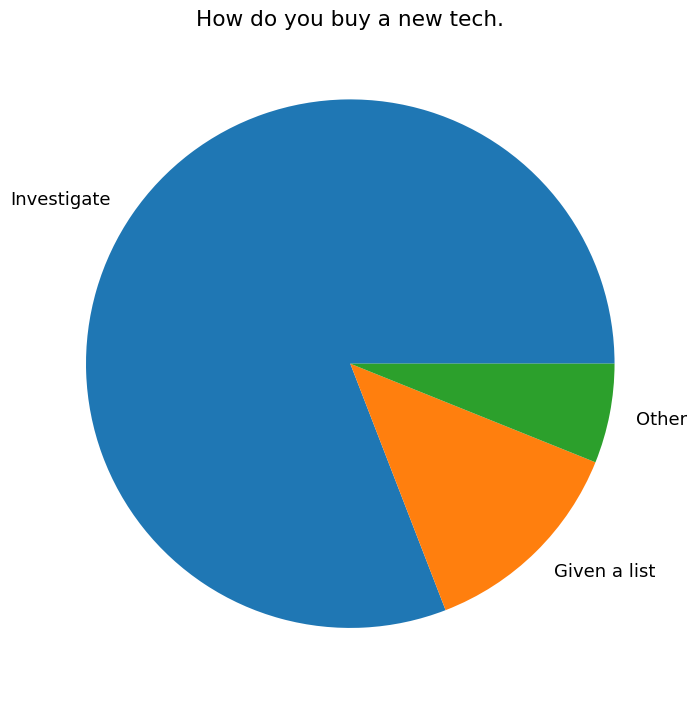

In [123]:
# sns_hist_plot(data,col=data_cols[16],figsize=(8,4),style=plt_style,rotation=90,if_preprocess=True)
fig, ax = plt.subplots()
plt.title('How do you buy a new tech.')
cnt_dta = text_sep_counter(data[data_cols[16]],seperator=';',if_count=True)
sizes = list(cnt_dta.values())
labels = list(cnt_dta.keys())
ax.pie(sizes,labels=labels)
fig.tight_layout()
plt.show()

In [124]:
schema.iloc[21,2]

'When buying a new tool or software, how do you discover and research available solutions? Select all that apply.'

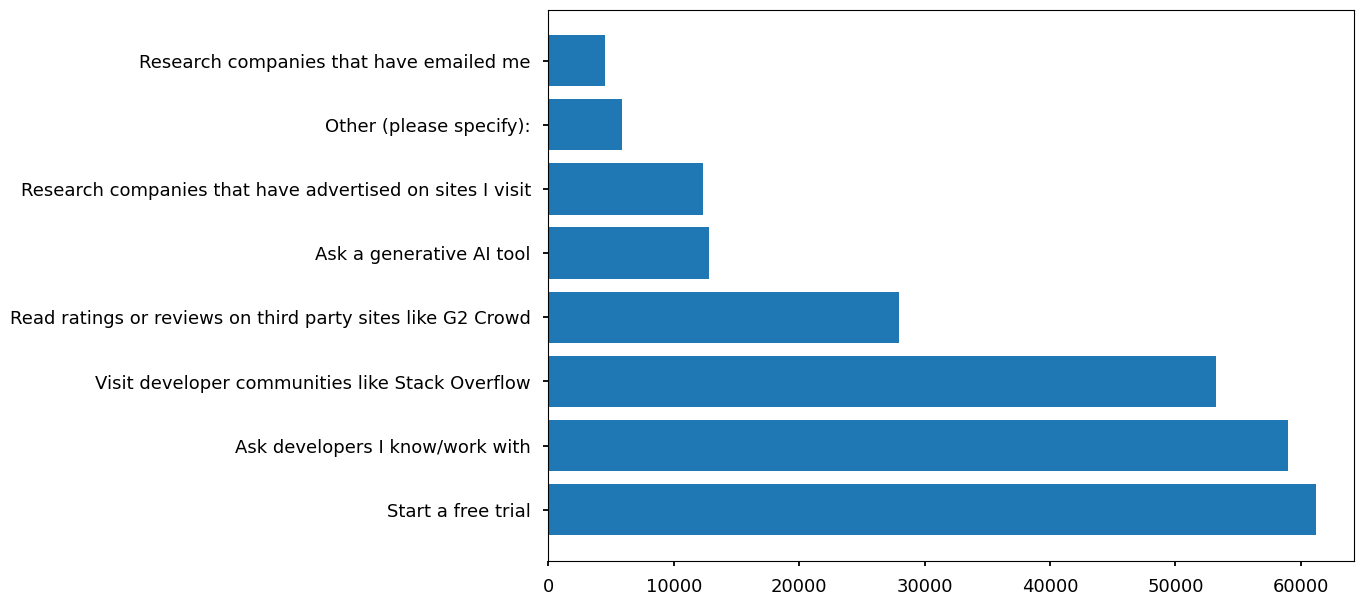

In [125]:
# sns_hist_plot(data,col=data_cols[17],figsize=(8,4),style=styles[14],rotation=90,if_preprocess=True)
plot_barh(data[data_cols[17]],if_preprocess=True,style=plt_style)

---
---
---

> ### Analysis of the participats distribution w.r.t their country: Qs Where do you live?

In [126]:
schema.iloc[22,2]

'Where do you live? <span style="font-weight: bolder;">*</span>'

In [127]:
#Loading world map to use in preseting the results
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'));

/var/folders/99/ns2bjzxd70xch1fw_63n29kw0000gn/T/ipykernel_18708/2159525927.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'));


#### Matching the names of the countries from two data set to plot the data on the map

Cleaning the country column from the data:

In [128]:
#Removing data with null values in country column:
data_cntry = get_org_data(data_req,na_threshold)
filt = (data_cntry['Country'].notnull())
data_cntry = data_cntry[filt]

#names of the some of the countries are two parts and to match it with the 
#data in map we will clean and keep only the first part of the string
data_cntry['Country']=data_cntry['Country'].apply(lambda x: x.strip().split(',')[0])

#names of the some of the countries in map and in the data are different we will correct those in data
data_cntry['Country']= data_cntry['Country'].replace(['Czech Republic',"Democratic People's Republic of Korea",'Viet Nam',
                                          'The former Yugoslav Republic of Macedonia','Bosnia and Herzegovina',
                                         'Central African Republic','United Kingdom of Great Britain and Northern Ireland'],
                                         ['Czechia','South Korea','Vietnam','North Macedonia','Bosnia and Herz'
                                          ,'Central African Rep','United Kingdom'])

number of removed rows: 0


Names of the some of the countries are different in the two dataset (the map data and the stack oveflow data), here we will fix and match those names

In [130]:
cntry_in_map = world['name'].value_counts().index.to_list()
def Country_name_Maching(x):
    found=False
    for cntry in cntry_in_map:
        if x in cntry or cntry in x:
            return_value = cntry
            found = True
            break
    if not found:
        return_value = x
    return return_value

data_cntry['Country']=data_cntry['Country'].apply(Country_name_Maching)

### Plotting the number of participants from each country:

In [131]:
CNTRY_GP_DATA = data_cntry.groupby('Country')
temp_ser = CNTRY_GP_DATA['ResponseId'].count()
world.set_index('name',inplace=True)

In [132]:
world = world.join(temp_ser)

Distribution of the number of the participants in the world

The gray area shows the missing values


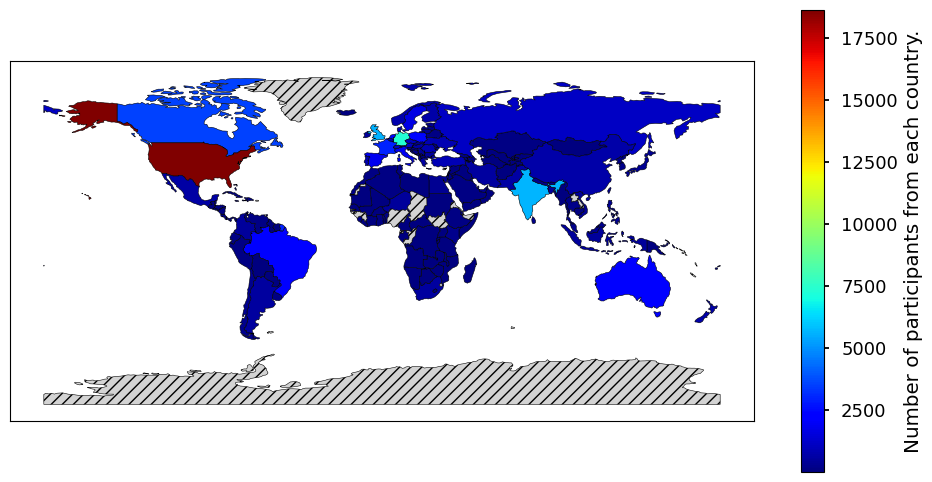

In [139]:
fig, ax = plt.subplots(1, 1,figsize=(12,6))
print("The gray area shows the missing values")
world.plot(column='ResponseId',
            ax=ax,
            legend=True,
            edgecolor="black",
            cmap='jet',  
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "hatch": "///",
            "label": "Missing values",},
            legend_kwds={'label': "Number of participants from each country.",
                         'orientation': "vertical"})
plt.xticks([])
plt.yticks([])
plt.show()

Distribution of the number of participants in the European countries

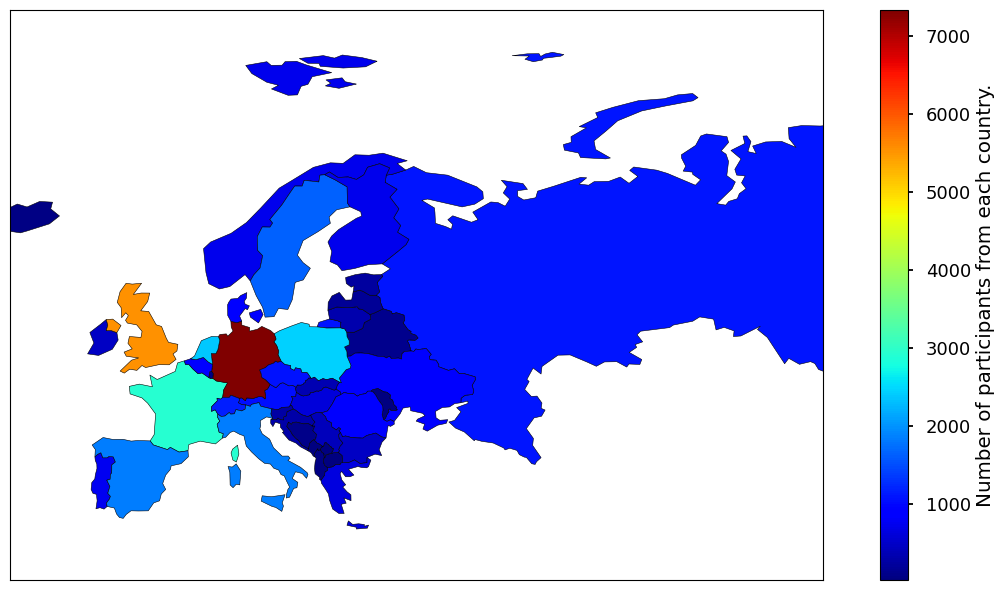

In [141]:
fig, ax = plt.subplots(1, 1,figsize=(12,6))
temp_world = world[world['continent']=='Europe']
temp_world.plot(column='ResponseId',
            ax=ax,
            legend=True,
            edgecolor="black",
            cmap='jet',  
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "hatch": "///",
            "label": "Missing values",},
            legend_kwds={'label': "Number of participants from each country.",
                         'orientation': "vertical"})
fig.tight_layout()
plt.xlim(-20,85)
plt.ylim(30,85)
plt.xticks([])
plt.yticks([])
plt.show()

---
---
---

### Analysis of the salary column:

### Cleaning the Salary Columns and converting the rates to USD according to rates in CurrencyConverter: we will keep the rows for which we have the conversion rate

In [145]:
#A Function to convers currency to USD:
selected_date = date(2021, 5, 10)
my_converter = lambda x: cc.convert(1, x, 'USD', date=selected_date)

#Removing data with null values in salary and currency column:
filt = (data_cntry['Currency'].notnull() & data_cntry['CompTotal'].notnull())
data_cntry = data_cntry[filt]

# Preprocessing Currency column to have the Currency seperated from the rest of the text:
data_cntry['Currency']=data_cntry['Currency'].apply(lambda x: x.strip().split()[0].upper())

#removing the rows for which we do not have a conversion rate in out data:
filt = [True if i.split()[0] in cc.currencies else 
        False for i in (data_cntry['Currency'])]
data_cntry = data_cntry[filt]

data_cntry['Conversion_rate'] = data_cntry['Currency'].apply(my_converter)

#Calculating salary in USD rate: data_cols[20]='CompTotal' -> salary in originla country currency
data_cntry['Salary_USD'] = data_cntry['Conversion_rate']*data_cntry['CompTotal']

#Removing unnessery Columns:
data_cntry.drop('Conversion_rate',axis=1,inplace=True)
# data.drop('Currency_Cuntry',axis=1,inplace=True)

### salary column 

In [146]:
data_cntry['Salary_USD'].sort_values(ascending=False)[:5]

49553    1.000000e+16
43556    2.470963e+15
35779    8.254087e+14
15397    7.214102e+09
65903    6.582165e+08
Name: Salary_USD, dtype: float64

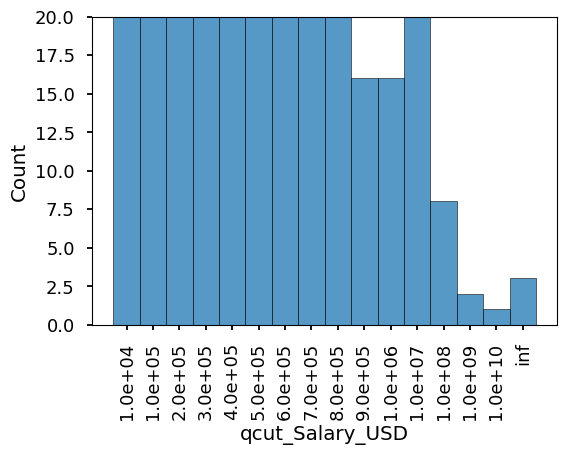

In [147]:
# Visualizing salary histogram
bins = [0,10000,100000,200000,300000,400000,500000,600000,700000,800000,
         900000,1000000,10000000,100000000,1000000000,10000000000,np.inf]
labels = [f'{i:.1e}' for i in bins[1:]]
data_cntry['qcut_Salary_USD'] = pd.cut(data_cntry['Salary_USD'],labels=labels,bins=bins)
sns_hist_plot(data_cntry['qcut_Salary_USD'],figsize=(6,4),style=None,rotation=90,if_preprocess=False)
plt.ylim([0,20])
plt.show()

### The salary column has got some out liers here we will remove the outliers:

In [148]:
salarar_range = [100,1e+6]
# filtering salary column and removing outliers less than 1000 and more than millions:
filt = ((data_cntry['Salary_USD'] < salarar_range[1]) & (data_cntry['Salary_USD'] > salarar_range[0] )) 
data_cntry = data_cntry[filt]

In [149]:
data_cntry['Salary_USD'].sort_values(ascending=False)[:5]

61330    980000.000000
29770    970000.000000
72502    949182.000000
64589    945575.463936
32250    940000.000000
Name: Salary_USD, dtype: float64

### Salary median for each country:

In [150]:
CNTRY_GP_DATA = data_cntry.groupby('Country')

In [151]:
temp_ser = CNTRY_GP_DATA['Salary_USD'].median()

In [152]:
temp_world2 = world.join(temp_ser)

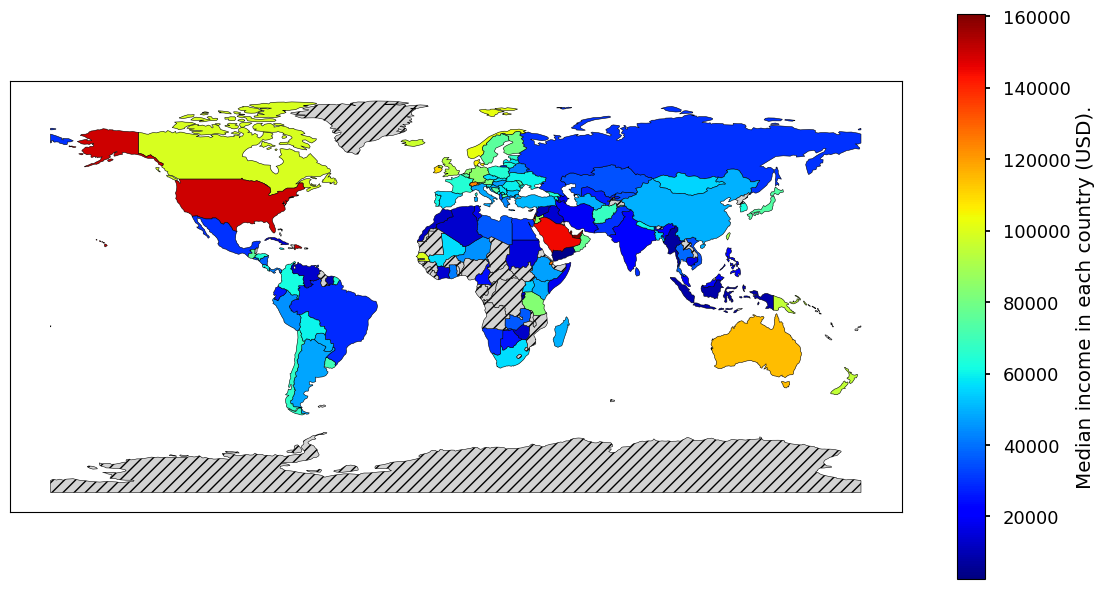

In [153]:
fig, ax = plt.subplots(1, 1,figsize=(12,6))
temp_world2.plot(column='Salary_USD',
            ax=ax,
            legend=True,
            edgecolor="black",
            cmap='jet',  
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "hatch": "///",
            "label": "Missing values",},
            legend_kwds={'label': "Median income in each country (USD).",
                         'orientation': "vertical"})
fig.tight_layout()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

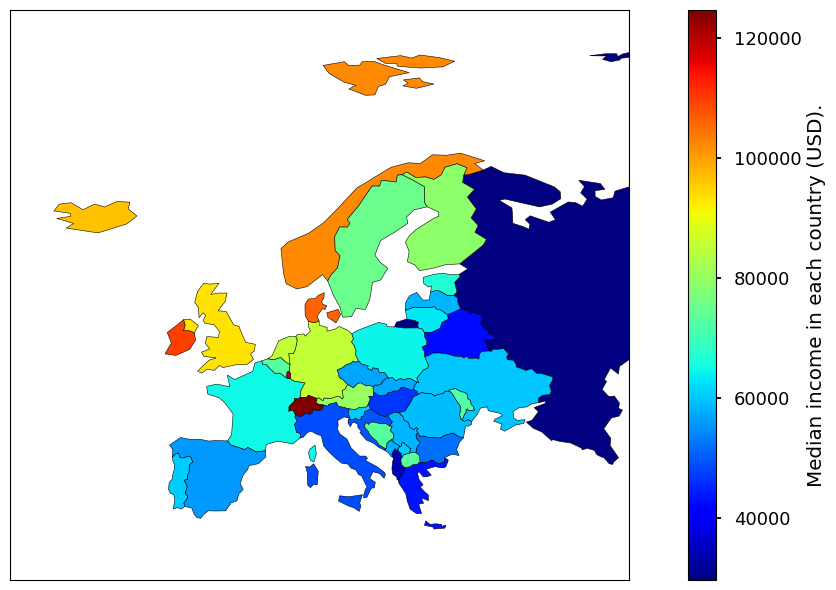

In [154]:
fig, ax = plt.subplots(1, 1,figsize=(12,6))
temp_world3 =temp_world2[temp_world2['continent']=='Europe']
temp_world3.plot(column='Salary_USD',
            ax=ax,
            legend=True,
            edgecolor="black",
            cmap='jet',  
            missing_kwds={
            "color": "lightgrey",
            "edgecolor": "k",
            "hatch": "///",
            "label": "Missing values",},
            legend_kwds={'label': "Median income in each country (USD).",
                         'orientation': "vertical"})

ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()
plt.xlim(-30,50)
plt.ylim(30,85)
plt.show()

---
---
---

### Educational level: 

In [155]:
Edleve_GP = data_cntry.groupby(['EdLevel'])

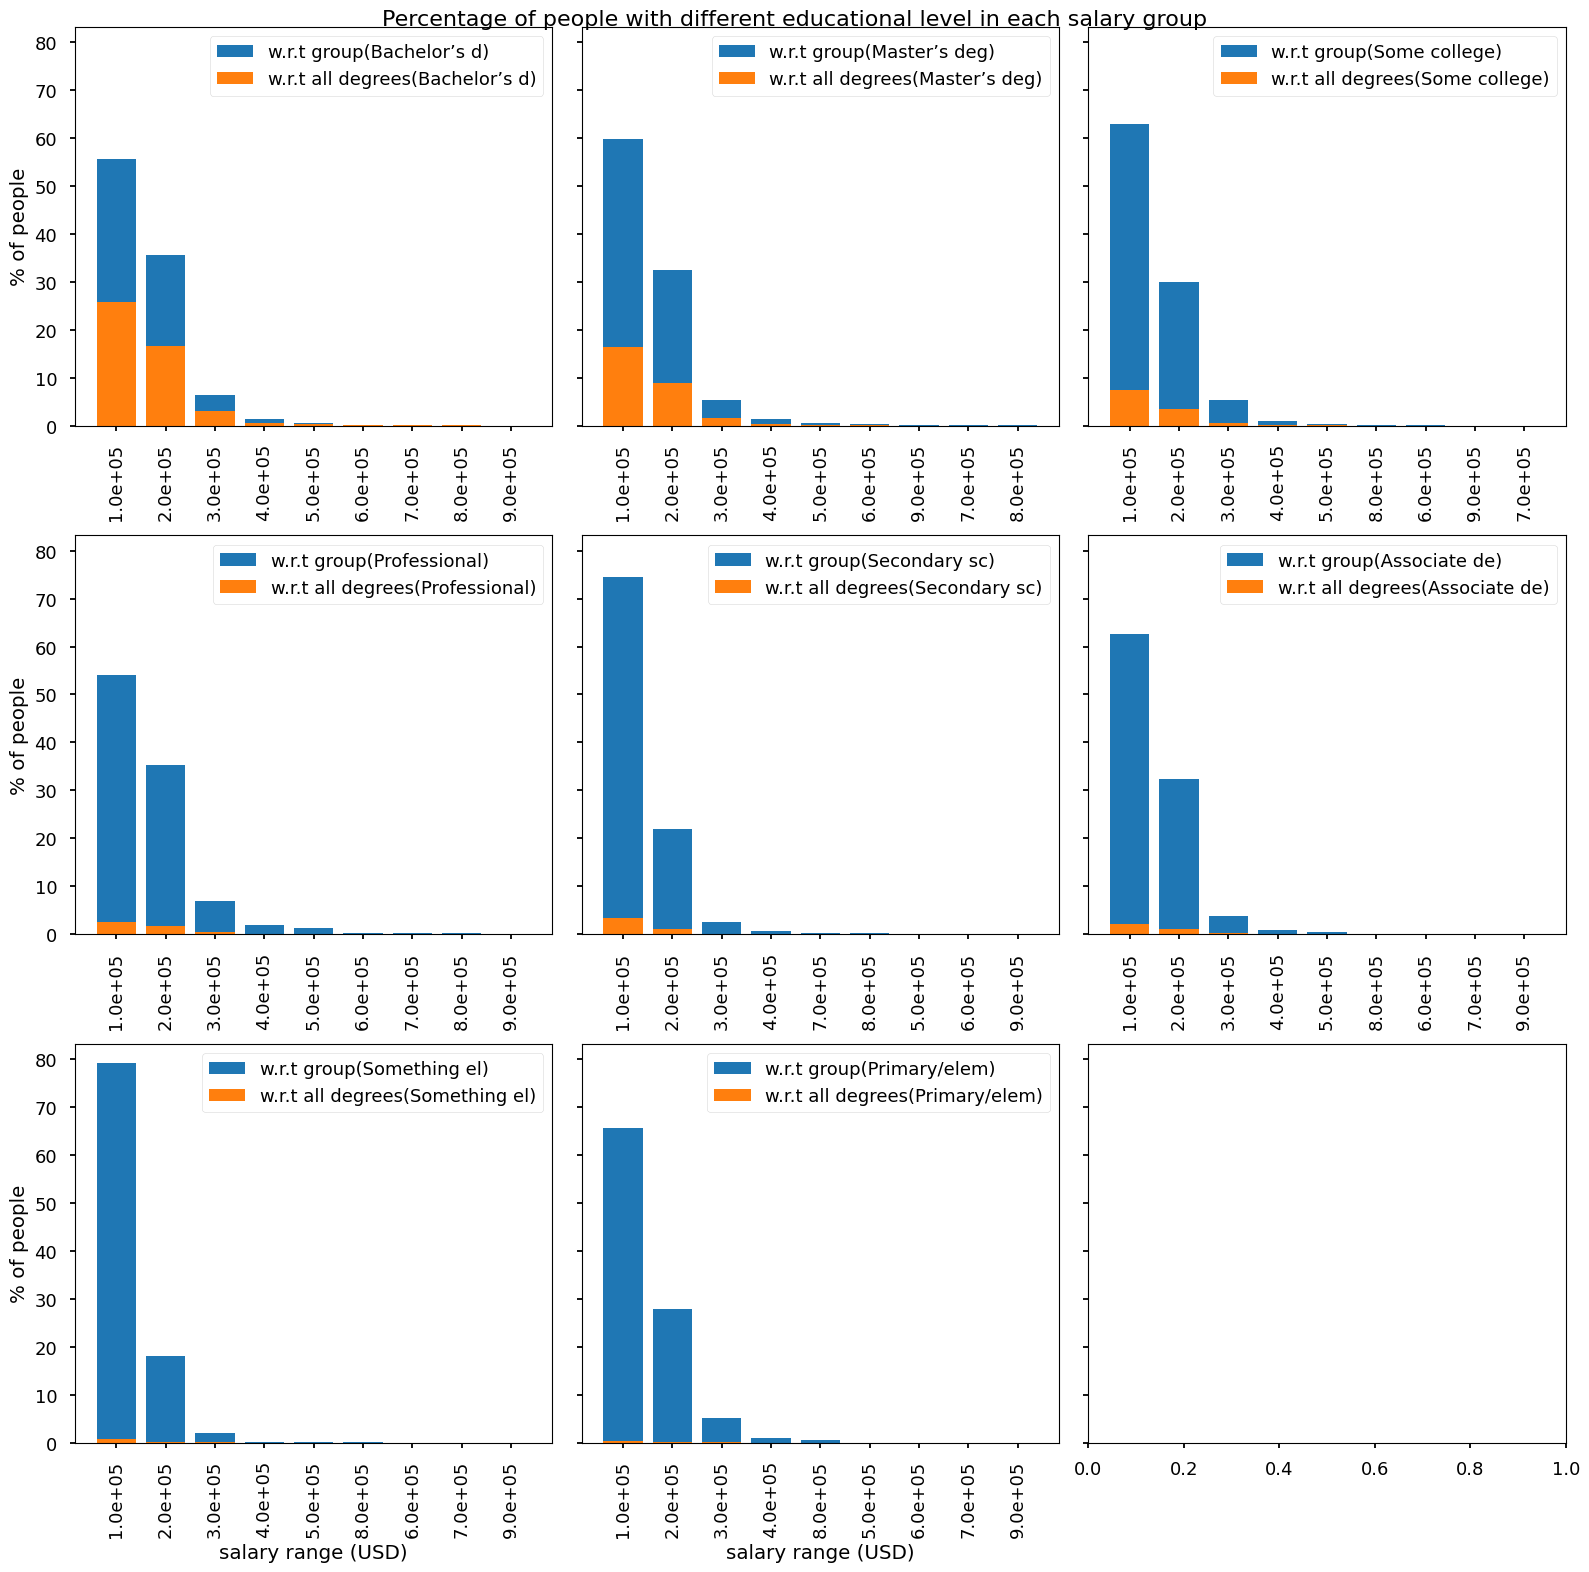

In [160]:
edlevels = data_cntry['EdLevel'].value_counts()
Tot_dataPoints = data_cntry['EdLevel'].count()
fig,axs = plt.subplots(3,3,figsize=(16,16),sharey=True)
fig.suptitle("Percentage of people with different educational level in each salary group", fontsize=16)
fig.subplots_adjust(wspace=0.03, hspace=0.4)
lbl,max_lbl = 0,len(edlevels.index)
bins = np.arange(0,1000000,100000)
labels = [f'{i:.1e}' for i in bins[1:]]
for i in range(3):
    if lbl>= max_lbl:
        break
    for j in range(3):
        if lbl>= max_lbl:
            break
        ax = axs[i,j]
        data_cntry['temp_Salary_USD'] = pd.cut(Edleve_GP.get_group((edlevels.index[lbl],))['Salary_USD'],labels=labels,bins=bins)
        
        cnt_dta = data_cntry['temp_Salary_USD'].value_counts()
        Ndata = data_cntry['temp_Salary_USD'].count()
        ax.bar(x=cnt_dta.index,height=cnt_dta/Ndata*100,label="w.r.t group"+'('+edlevels.index[lbl][:12]+')')
        ax.bar(x=cnt_dta.index,height=cnt_dta/Tot_dataPoints*100,label="w.r.t all degrees"+'('+edlevels.index[lbl][:12]+')')
        ax.tick_params('x',labelrotation=90)
        if i==2:
            ax.set_xlabel("salary range (USD)")
        if j==0:
            ax.set_ylabel("% of people")
        ax.legend()
        lbl+=1
fig.tight_layout()
# plt.xlabel("Slaray USD")
plt.show()
data_cntry.drop('temp_Salary_USD',axis=1,inplace=True)

In [164]:
data_cols[13]

'DevType'

In [169]:
occ_GP = data_cntry.groupby('DevType')
occ_plot_data = occ_GP['Salary_USD'].mean()
occ_plot_data = occ_plot_data.sort_values(ascending=False)

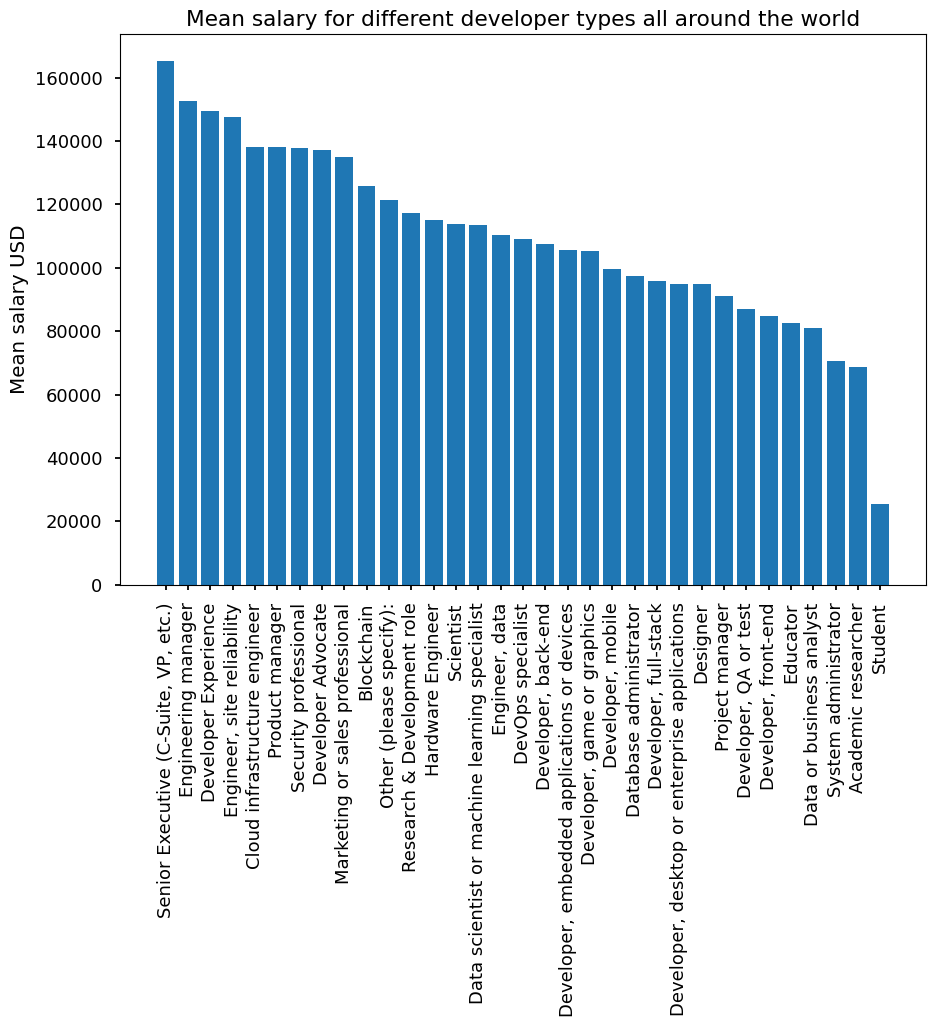

In [171]:
fix,ax = plt.subplots(1,1)
ax.bar(x=occ_plot_data.index,height=occ_plot_data.values,alpha=1)
plt.ylabel("Mean salary USD")
plt.title("Mean salary for different developer types all around the world")
plt.xticks(rotation=90)
plt.show()

In [181]:
erope_countrie = world[world['continent']=="Europe"].index

In [190]:
filt_europe = data_cntry['Country'].isin(erope_countrie)

In [191]:
data_europe = data_cntry[filt_europe]

In [197]:
occ_GP = data_europe.groupby('DevType')
occ_plot_data = occ_GP['Salary_USD'].mean()
occ_plot_data = occ_plot_data.sort_values(ascending=False)

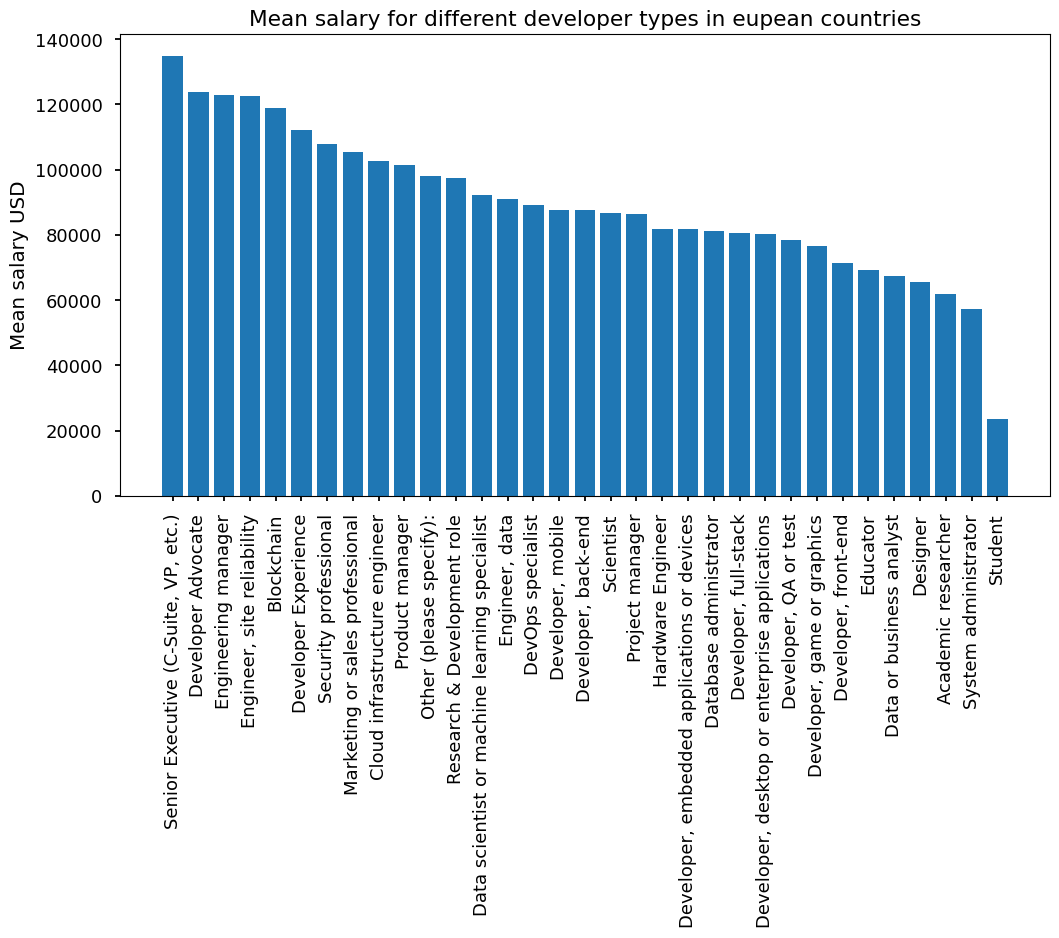

In [208]:
fix,ax = plt.subplots(1,1,figsize=(12,6))
ax.bar(x=occ_plot_data.index,height=occ_plot_data.values,alpha=1)
plt.ylabel("Mean salary USD")
plt.title("Mean salary for different developer types in eupean countries")
plt.xticks(rotation=90)
plt.show()

---
---
---

## technology and tech culture

###  Coding Languages:

In [209]:
schema.iloc[26,2]

'Which <b>programming, scripting, and markup languages</b> have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)'

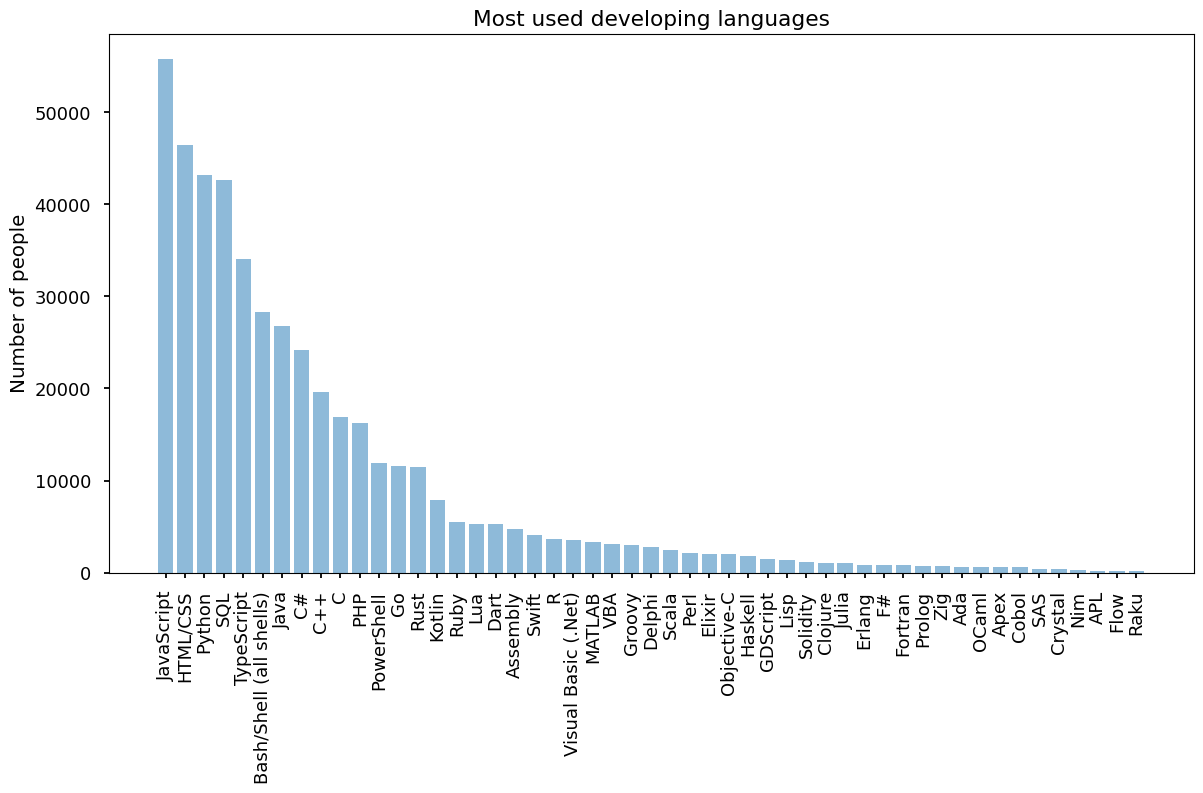

In [243]:
dev_lang = get_sin_DF(data[data_cols[21]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(14,7))
plt.title("Most used developing languages")
ax.bar(x=dev_lang.index,height=dev_lang[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

### DataBases (DBMS)

In [213]:
schema.iloc[27,2]

'Which <b>database environments </b>have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the database and want to continue to do so, please check both boxes in that row.)'

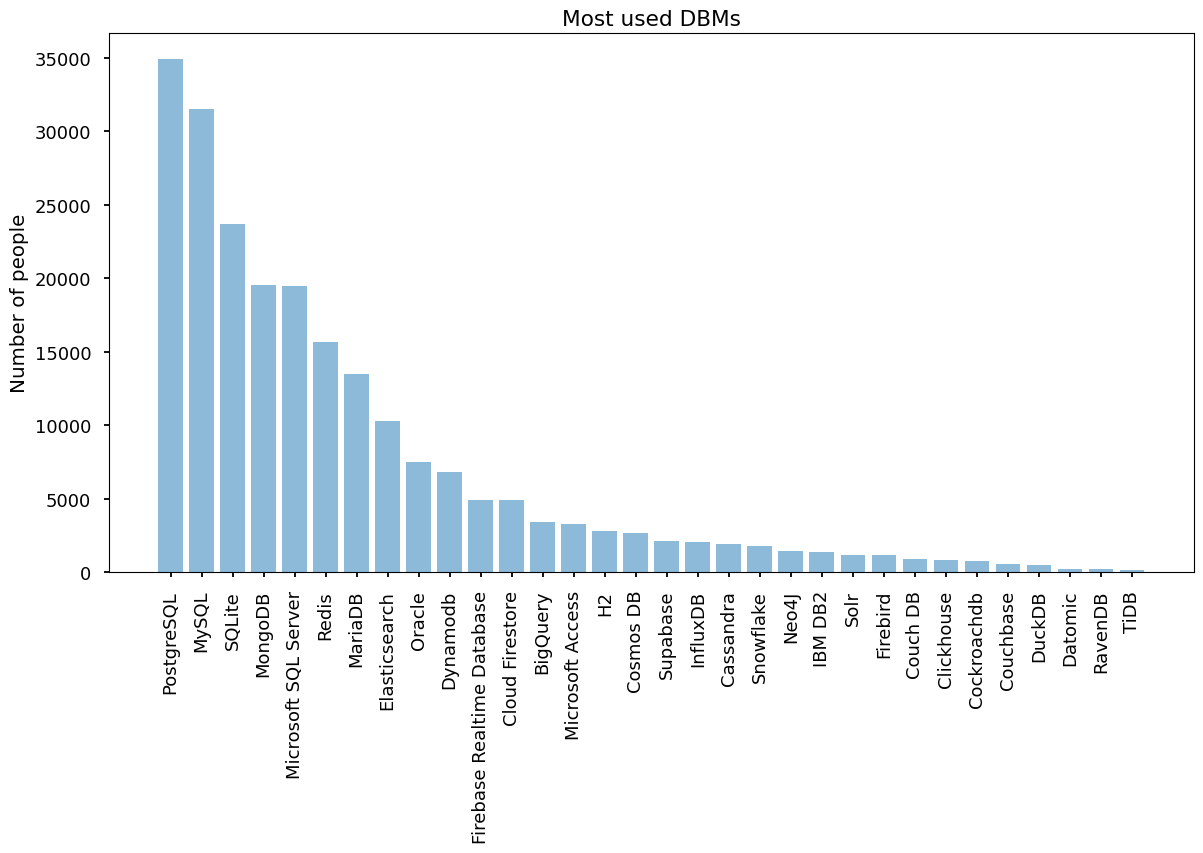

In [246]:
DBSs = get_sin_DF(data[data_cols[23]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(14,7))
plt.title("Most used DBMs")
ax.bar(x=DBSs.index,height=DBSs[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

###  Cloud platforms:

In [217]:
schema.iloc[28,2]

'Which <b>cloud platforms</b> have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the platform and want to continue to do so, please check both boxes in that row.)'

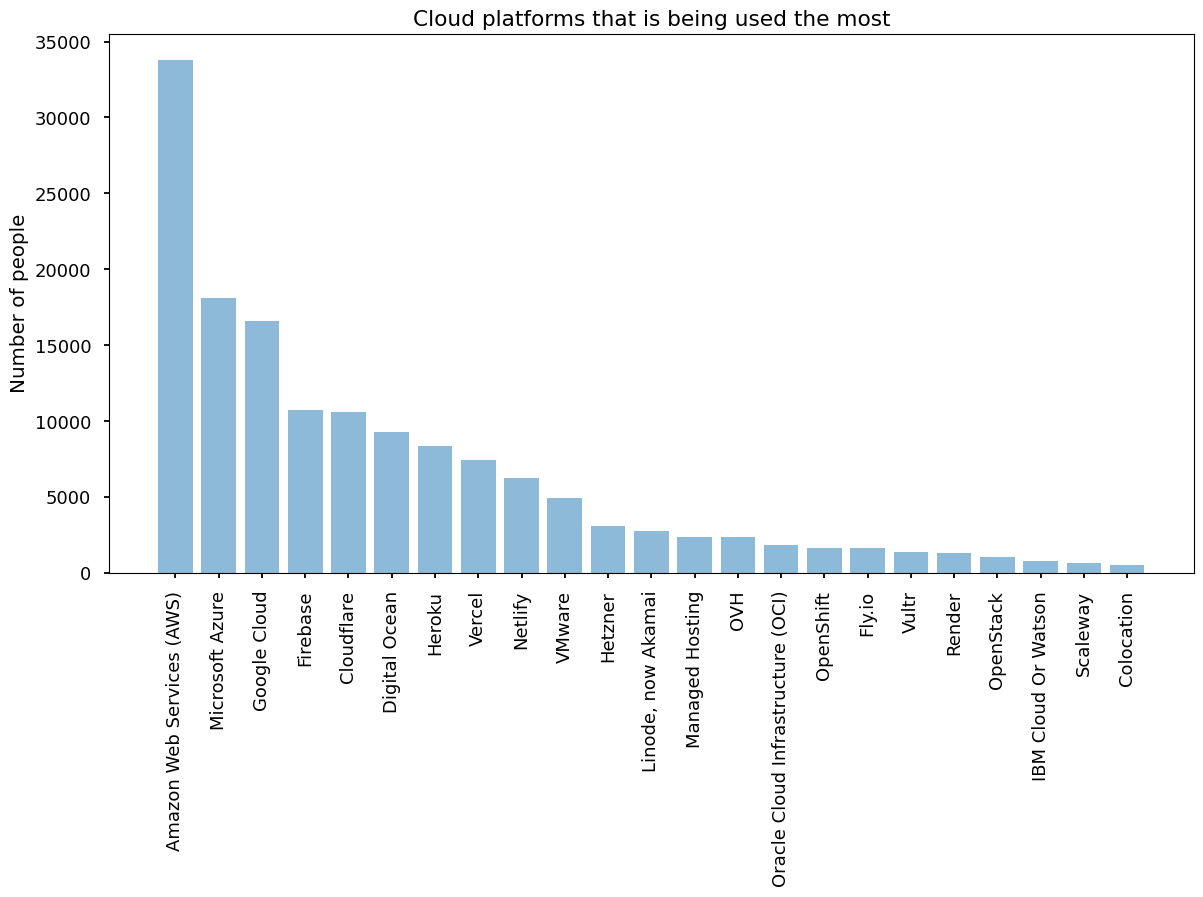

In [248]:
Cloud_P = get_sin_DF(data[data_cols[25]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(14,7))
plt.title("Cloud platforms that is being used the most")
ax.bar(x=Cloud_P.index,height=Cloud_P[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

###  web frameworks and web technologies

In [221]:
schema.iloc[29,2]

'Which <b>web frameworks and web technologies</b> have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the framework and want to continue to do so, please check both boxes in that row.)'

In [249]:
data_cols[27]

'WebframeHaveWorkedWith'

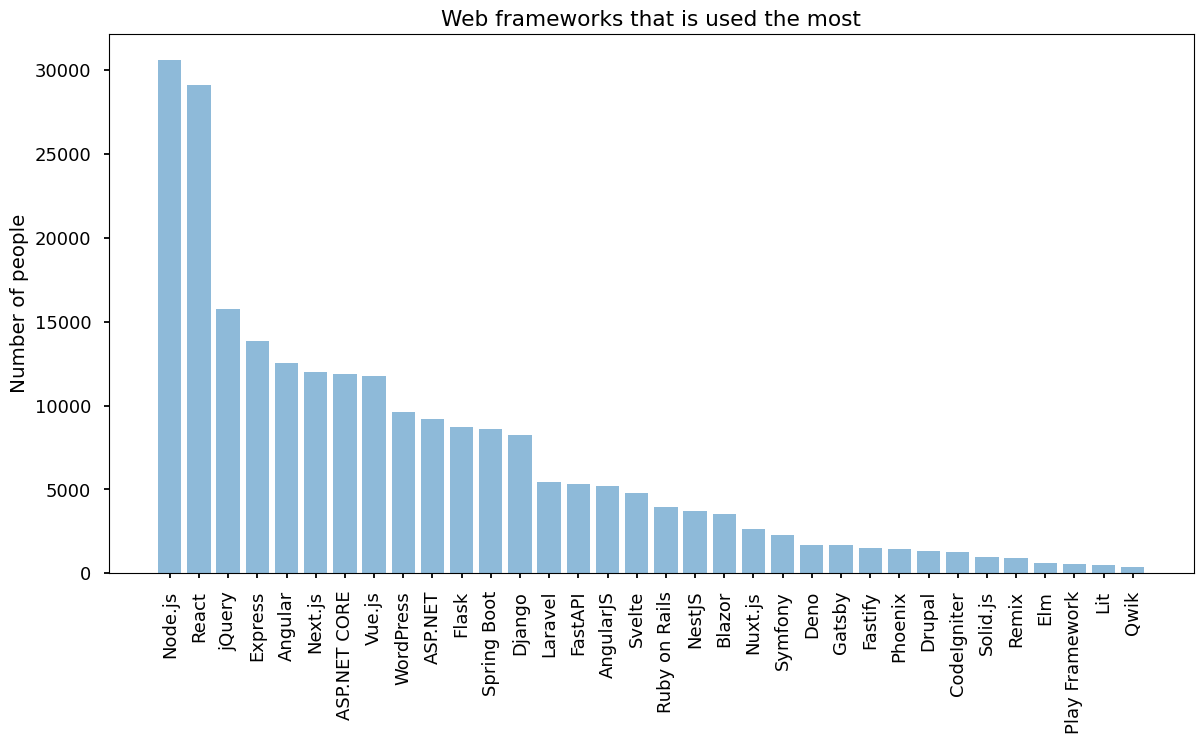

In [222]:
Web_F = get_sin_DF(data[data_cols[27]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(14,7))
plt.title("Web frameworks that is used the most")
ax.bar(x=Web_F.index,height=Web_F[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

In [223]:
schema.iloc[29,2]

'Which <b>web frameworks and web technologies</b> have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the framework and want to continue to do so, please check both boxes in that row.)'

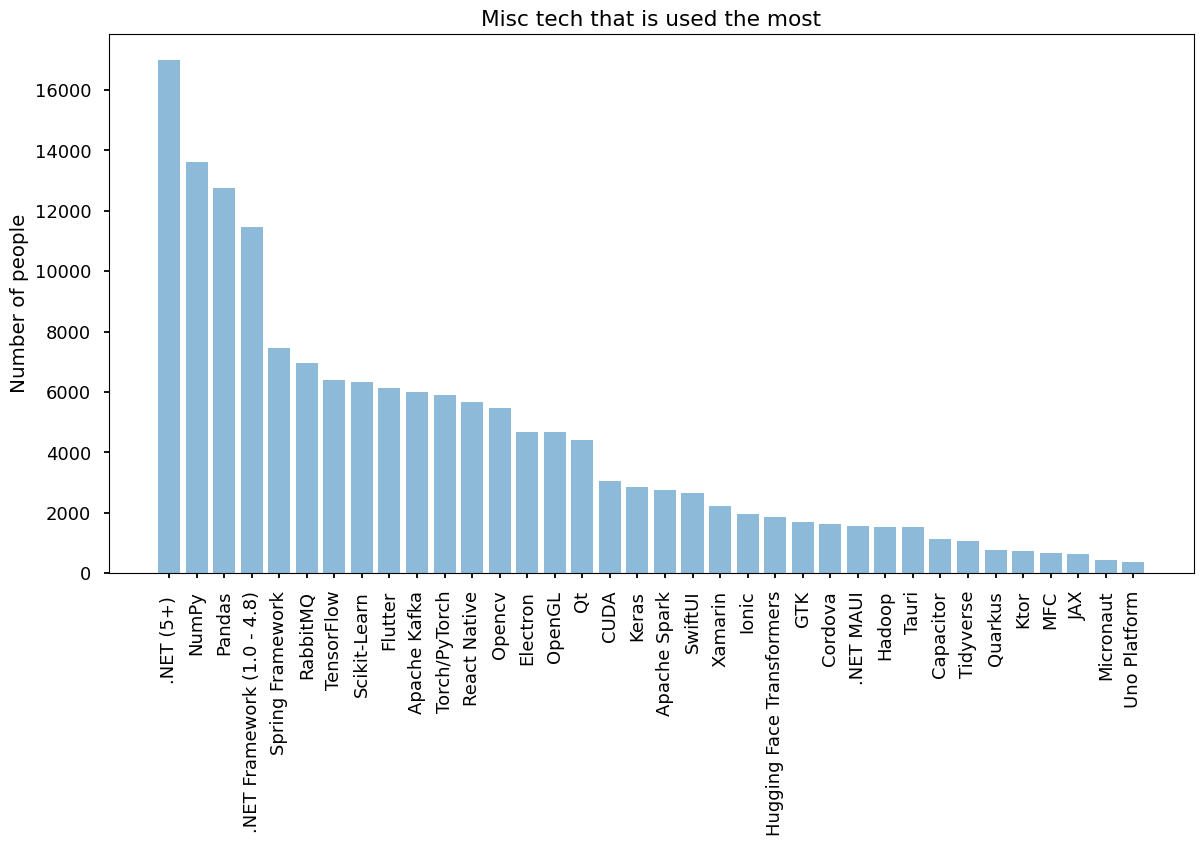

In [251]:
Web_F = get_sin_DF(data[data_cols[29]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(14,7))
plt.title("Misc tech that is used the most")
ax.bar(x=Web_F.index,height=Web_F[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

In [225]:
schema.iloc[31,2]

'Which <b>developer </b><strong>tools for compiling, building and testing</strong> have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the technology and want to continue to do so, please check both boxes in that row.)'

In [253]:
data_cols[31]

'ToolsTechHaveWorkedWith'

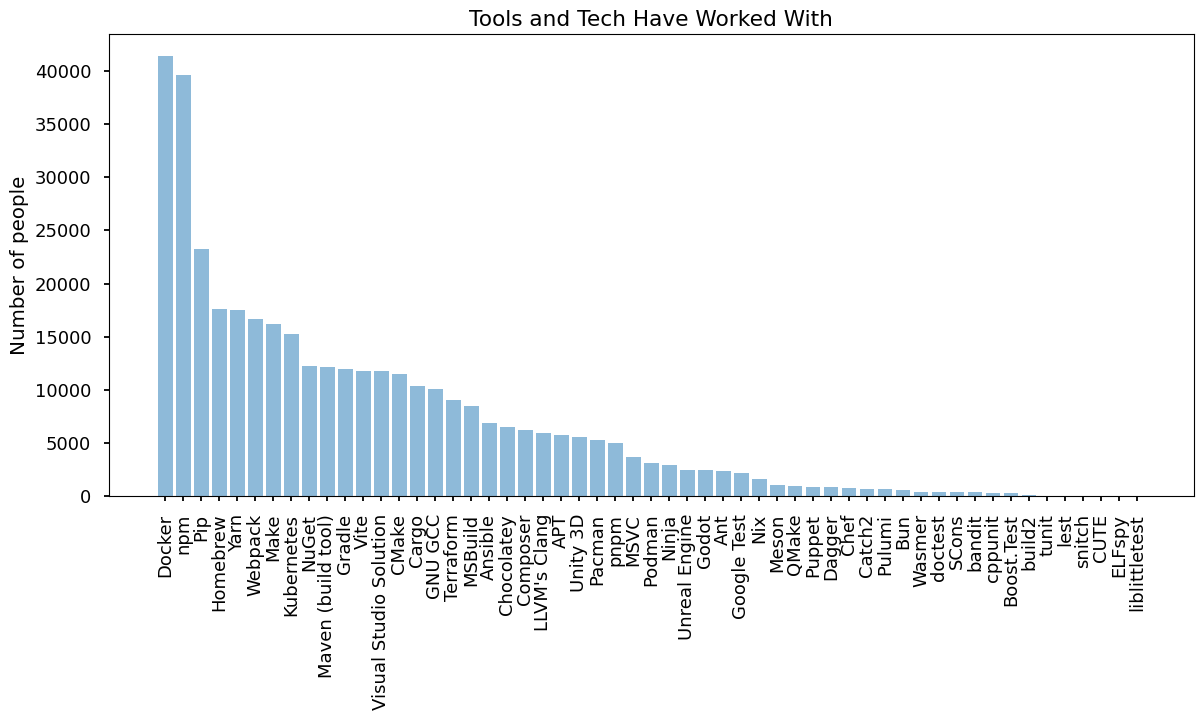

In [255]:
dev_tools = get_sin_DF(data[data_cols[31]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(14,6))
plt.title("Tools and Tech Have Worked With")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

In [256]:
schema.iloc[32,2]

'Which <strong>development environments</strong> did you use regularly over the past year, and which do you want to work with over the next year? Please check all that apply.'

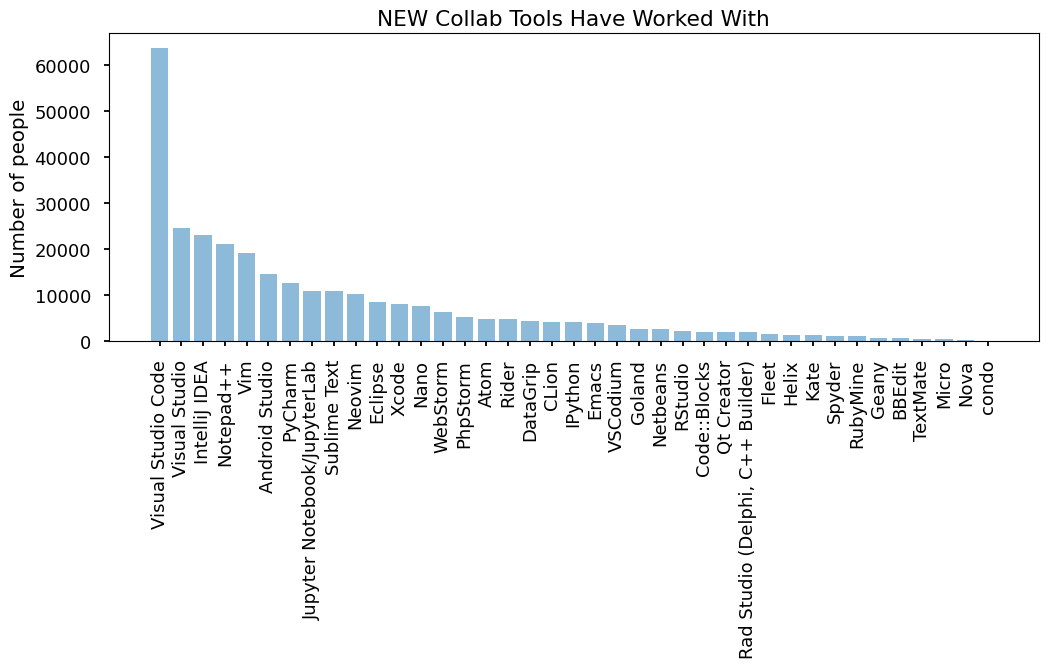

In [261]:
dev_tools = get_sin_DF(data[data_cols[33]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(12,4))
plt.title("NEW Collab Tools Have Worked With")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

---
---
---


In [229]:
schema.iloc[33,2]

'What is the primary <b>operating system</b> in which you work? '

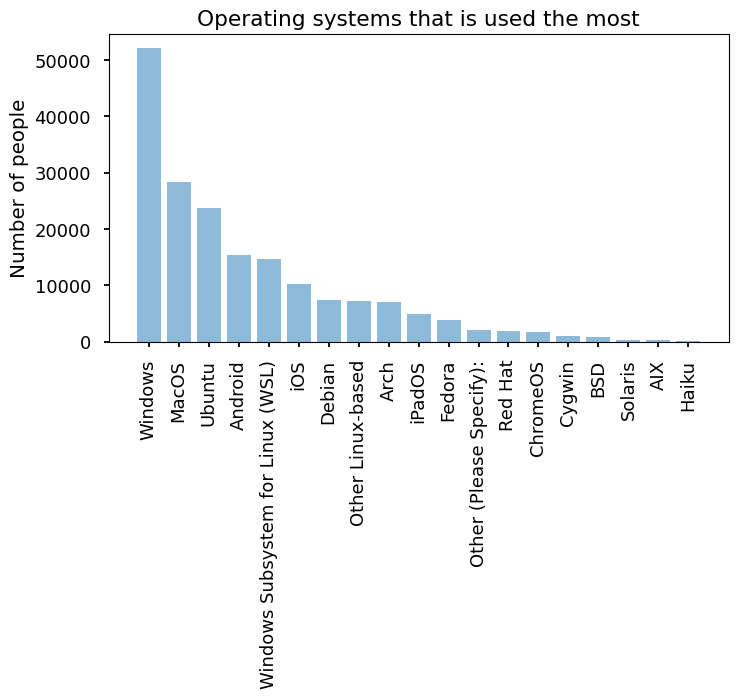

In [230]:
dev_tools = get_sin_DF(data[data_cols[35]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(8,4))
plt.title("Operating systems that is used the most")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

In [231]:
schema.iloc[34,2]

'Which <b>collaborative work management and/or code documentation tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply'

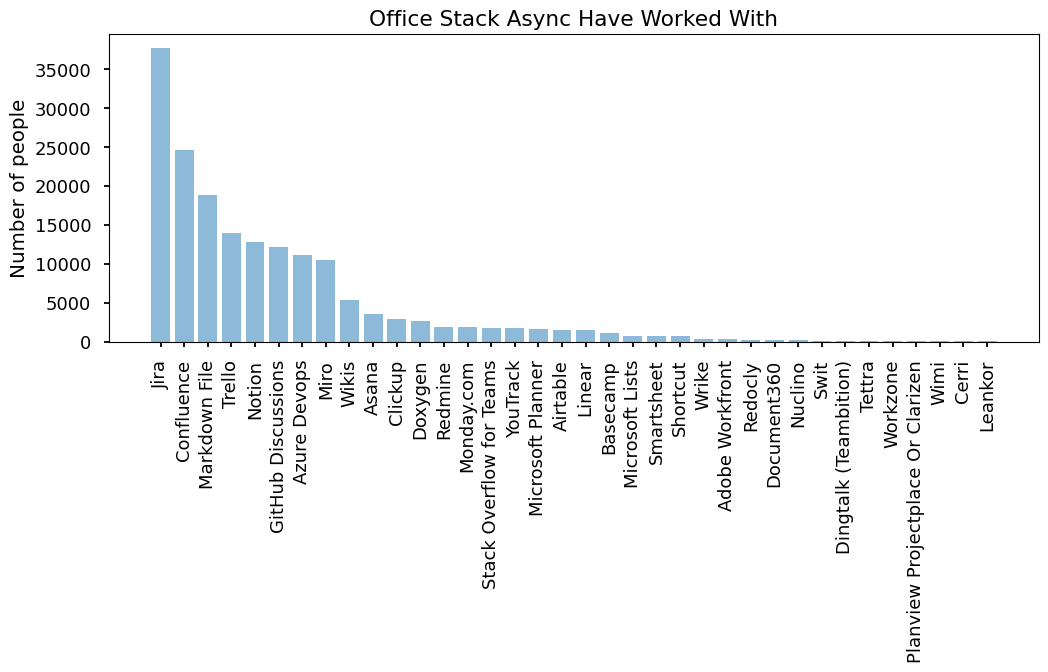

In [267]:
dev_tools = get_sin_DF(data[data_cols[37]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(12,4))
plt.title("Office Stack Async Have Worked With")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

In [233]:
schema.iloc[35,2]

'Which <b>communication tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply'

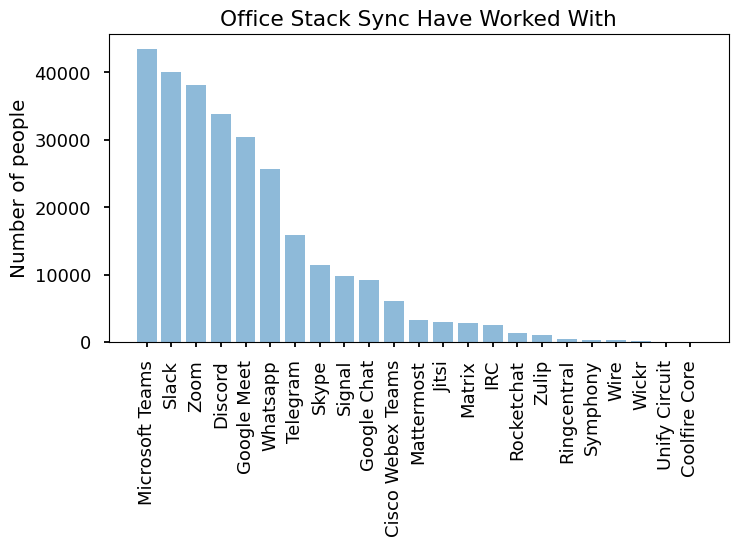

In [234]:
dev_tools = get_sin_DF(data[data_cols[39]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(8,4))
plt.title("Office Stack Sync Have Worked With")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

---
---
---


### AI TOOLS BEING USED

In [235]:
schema.iloc[36,2]

'Which <b>AI-powered search tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply.'

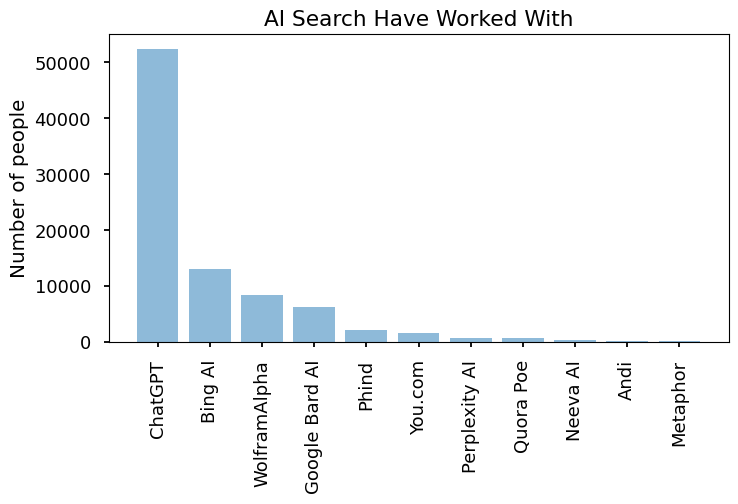

In [236]:
dev_tools = get_sin_DF(data[data_cols[41]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(8,4))
plt.title("AI Search Have Worked With")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()

In [237]:
schema.iloc[37,2]

'Which <b>AI-powered developer tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply'

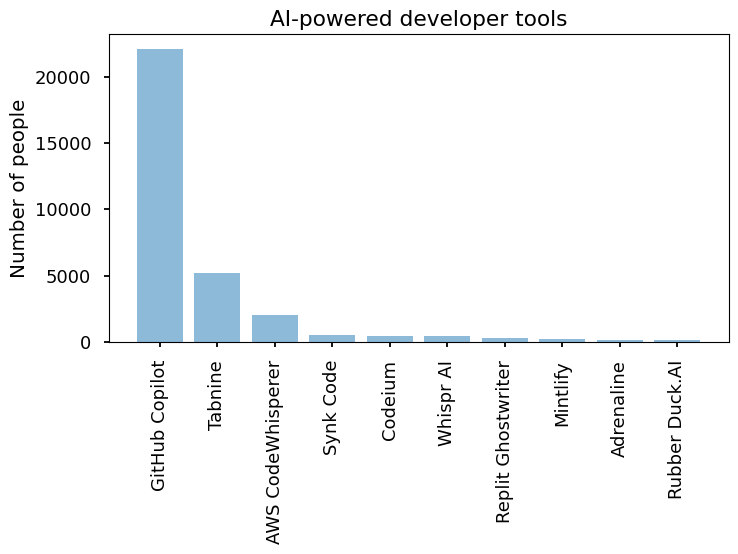

In [238]:
dev_tools = get_sin_DF(data[data_cols[43]],sort=True,seperator=';')
fig,ax = plt.subplots(1,1,figsize=(8,4))
plt.title("AI-powered developer tools")
ax.bar(x=dev_tools.index,height=dev_tools[0].values,alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of people")
plt.show()